***Using	the	hotel	reviews subset	of	the	suggestion	mining	dataset	provided	at***
https://github.com/sapna13/Suggestion-Mining-Datasets 

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import nltk
from yellowbrick.cluster import KElbowVisualizer
import itertools
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.util import ngrams
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re as re
from wordcloud import WordCloud ,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans 
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import seaborn as sns
from PIL import Image
import matplotlib_venn as venn
from scipy.sparse import csr_matrix, hstack, vstack
import collections
import os,gc,time,warnings
import operator
from functools import reduce
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
import gensim
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# custom packages that need to normalize the words
import import_ipynb 
from contractions_list import CONTRACTION_MAP
from slangs_list import SLANGS_MAP

importing Jupyter notebook from contractions_list.ipynb
importing Jupyter notebook from slangs_list.ipynb


#### ***Read the data, and seperate them to suggestions and non-suggestions***
#### *Clean the data*

In [ ]:
# read the csv data 
trainingData = pd.read_csv("./dataset/hotel-train.csv",header=None,skipinitialspace = True)
testData = pd.read_csv("./dataset/hotel-test.csv",header=None,skipinitialspace = True)

# name the columns
trainingData.columns = ['hotel_name', 'reviews','label']
testData.columns = ['hotel_name', 'reviews','label']

In [ ]:
# check the shape of training and testing dataset
print(trainingData.shape)
print(testData.shape)

(7534, 3)
(808, 3)


In [ ]:
#Take suggestions as 1 and non-suggetions as 0
suggestion_count = (trainingData['label'].values == 1).astype(int).sum()
non_suggestion_count = (trainingData['label'].values == 0).astype(int).sum()

# print total sentences, total suggestion sentences and non-suggestion sentences
print("Total sentences : " + str(trainingData.shape[0]))
print("Total suggestions : " + str(suggestion_count))
print("Total non-suggestions : " + str(non_suggestion_count))

Total sentences : 7534
Total suggestions : 448
Total non-suggestions : 7086


#### Data Cleaning

In [ ]:
# Check null or NaN values are present in the training data and testing data
print(testData.isnull().values.any())
print(trainingData.isnull().values.any())

False
False


In [ ]:
# Clean training data and testing data
# appostropis look and fix
def appos_look_up(text):
    words = text.split()
    new_text = []
    for word in words:
        word_s = word.lower()
        if word_s in CONTRACTION_MAP:
            new_text.append(CONTRACTION_MAP[word_s])
        else:
            new_text.append(word)
    apposed = " ".join(new_text)
    return apposed

# remove html tags
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

# remove line seperators
def remove_line_seperators(string):
    result=re.sub("\\n", "", string)
    return result

# seperate digit with text
def separate_digit_text(text):
    regex_patter = re.compile(r'([\d]+)([a-zA-Z]+)')
    clean_text = regex_patter.sub(r'\1 \2', text)
    return clean_text

# check slangs look up with slangs data
def slang_look_up(text):
    words = text.split()
    new_text = []
    for word in words:
        word_s = word.lower()
        if word_s in SLANGS_MAP:
            new_text.append(SLANGS_MAP[word_s])
        else:
            new_text.append(word)
    slanged = " ".join(new_text)
    return slanged

# remove repeated characters
def remove_repeated_characters(text):
    regex_pattern = re.compile(r'(.)\1+')
    clean_text = regex_pattern.sub(r'\1\1', text)
    return clean_text

# remove punctuations
def remove_punctuations(text):
    test_punc_removed = [(ch if ch not in string.punctuation else " ") for ch in text ]
    test_punc_removed_join = ''.join(test_punc_removed)
    return test_punc_removed_join

# remove extra space
def remove_extra_space(text):
    clean_text = ' '.join(text.strip().split())
    return clean_text

# remove single character words
def remove_single_char_word(text):
    words = text.split()
    filter_words = [word for word in words if len(word) > 1]
    return " ".join(filter_words)

# clean all text
def cleantext(text):
    text_cleaned= remove_line_seperators(
        remove_single_char_word(
            remove_extra_space(
                remove_punctuations(
                    remove_repeated_characters(
                        slang_look_up(
                                appos_look_up(remove_tags(text)            
                            )
                        )
                    )
                )
            )
        )
    )
    text_cleaned=separate_digit_text(text_cleaned)
    return text_cleaned

In [ ]:
#clean training data
trainingData_ = trainingData.copy()
trainingData['reviews_fixed']=trainingData['reviews'].apply(lambda cw : cleantext(cw))
trainingData.head()

,hotel_name,reviews,label,reviews_fixed
0,berlin-hotel-190599-review-1.json_0,This hotel was very modern and sleek.,0,This hotel was very modern and sleek
1,berlin-hotel-190599-review-1.json_1,"Beautiful, well-laid out, albeiit small rooms.",0,Beautiful well laid out albeiit small rooms
2,berlin-hotel-190599-review-1.json_2,Fantastic breakfast with an incredible selecti...,0,Fantastic breakfast with an incredible selecti...
3,berlin-hotel-190599-review-1.json_3,the staff were uber-helpful.,0,the staff we are uber helpful
4,berlin-hotel-190599-review-1.json_4,Great location in front of a u-bahn stop.,0,Great location in front of bahn stop


In [ ]:
#clean test data
testData_ = testData.copy()
testData['reviews_fixed'] = testData['reviews'].apply(lambda cw : cleantext(cw))
testData.head()

,hotel_name,reviews,label,reviews_fixed
0,amsterdam-hotel-189387-review-16.json_4,"For a lovely breakfast, turn left out of the f...",1,For lovely breakfast turn left out of the fron...
1,amsterdam-hotel-189387-review-17.json_11,If you catch them right your in a 4 star hotel...,1,If you catch them right your in star hotel if ...
2,amsterdam-hotel-189387-review-18.json_13,and travelers should avoid it if they are look...,1,and travelers should avoid it if they are look...
3,amsterdam-hotel-189387-review-22.json_9,On thing I liked was just a block away was an ...,1,On thing liked was just block away was an Albe...
4,amsterdam-hotel-189387-review-23.json_7,"Might be a good place for tourists, but try an...",1,Might be good place for tourists but try anoth...


***Tokenize the cleaned reviews***

In [ ]:
#Instansiate tokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# training data tokenize
trainingData['tokenized_reviews'] = trainingData['reviews_fixed'].apply(lambda x : tokenizer.tokenize(x.lower()))
trainingData['tokenized_reviews'].head()

0         [this, hotel, was, very, modern, and, sleek]
1    [beautiful, well, laid, out, albeiit, small, r...
2    [fantastic, breakfast, with, an, incredible, s...
3                 [the, staff, we, are, uber, helpful]
4         [great, location, in, front, of, bahn, stop]
Name: tokenized_reviews, dtype: object

In [ ]:
# test data tokenize
testData['tokenized_reviews'] = testData['reviews_fixed'].apply(lambda x : tokenizer.tokenize(x.lower()))
testData['tokenized_reviews'].head()

0    [for, lovely, breakfast, turn, left, out, of, ...
1    [if, you, catch, them, right, your, in, star, ...
2    [and, travelers, should, avoid, it, if, they, ...
3    [on, thing, liked, was, just, block, away, was...
4    [might, be, good, place, for, tourists, but, t...
Name: tokenized_reviews, dtype: object

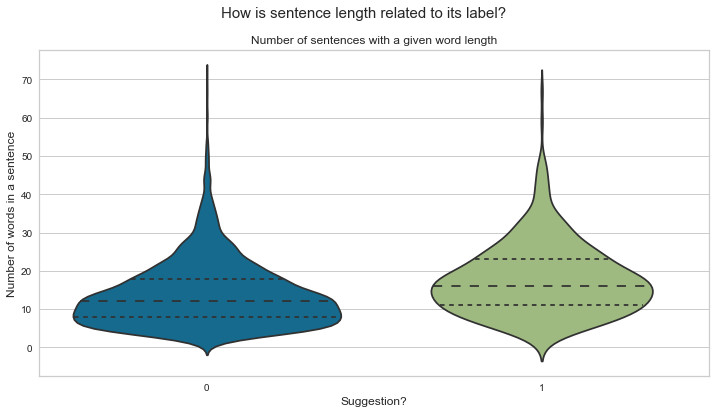

2928

In [ ]:
# plot of sentence length against label
df = trainingData.copy(deep=True)
df['count_word'] = trainingData['reviews'].apply(lambda x : len(x.split()))
plt.figure(figsize = (12, 6))
plt.suptitle("How is sentence length related to its label?", fontsize = 15)
count_word = df['count_word'].astype(int)
df['count_word'].loc[df['count_word'] > 100] = 100
plt.plot()
sns.violinplot(y = 'count_word', x = 'label', data = df, split = True, inner = "quart")
plt.xlabel('Suggestion?', fontsize = 12)
plt.ylabel('Number of words in a sentence', fontsize = 12)
plt.title("Number of sentences with a given word length", fontsize = 12)
plt.show()

del(df)
gc.collect()

In [ ]:
# training data spilit in to suggestion, non-suggestion dataframes
suggestion_df =trainingData.loc[trainingData['label'].values == 1]
non_suggestion_df=trainingData.loc[trainingData['label'].values == 0]

In [ ]:
# shape of suggestion_df
suggestion_df.shape

(448, 5)

In [ ]:
# shape of non_suggestion_df
non_suggestion_df.shape

(7086, 5)

In [ ]:
# method to make tokens in to array
def tokens_to_array(arr,words):
    for i in range(len(arr)):
        if(len(arr[i])>0):
            words.append(arr[i])

In [ ]:
# Unique tokens for suggestions
# no of tokens suggestion
suggestion_tokens=[]
suggestion_df['tokenized_reviews'].apply(lambda x : tokens_to_array(x,suggestion_tokens))
print("Total Suggestion tokens:"+(str)(len(suggestion_tokens)))

#no of unique suggestion tokens
unique_suggestion_tokens = set(suggestion_tokens)
print("Unique Suggestion tokens:"+(str)(len(unique_suggestion_tokens)))

Total Suggestion tokens:7738
Unique Suggestion tokens:1705


In [ ]:
# Unique tokens for non-suggestions
# no of tokens non suggestion
non_suggestion_tokens=[]
non_suggestion_df['tokenized_reviews'].apply(lambda x : tokens_to_array(x,non_suggestion_tokens))
print("Total Non-Suggestion tokens:"+(str)(len(non_suggestion_tokens)))

#no of unique non suggestion tokens
unique_non_suggestion_tokens = set(non_suggestion_tokens)
print("Unique Non-Suggestion tokens:"+(str)(len(unique_non_suggestion_tokens)))

Total Non-Suggestion tokens:95922
Unique Non-Suggestion tokens:7083


In [ ]:
print("Total sentences : " + str(trainingData.shape[0]))
print("Total suggestions : " + str(suggestion_count))
print("Total non-suggestions : " + str(non_suggestion_count))


# total tokens in dataset
total_tokens =[]
trainingData['tokenized_reviews'].apply(lambda x : tokens_to_array(x,total_tokens))
print("\nTotal tokens:"+(str)(len(total_tokens)))

#no of unique non suggestion tokens
unique_total_tokens = set(total_tokens)
print("Total unique tokens:"+(str)(len(unique_total_tokens)))

Total sentences : 7534
Total suggestions : 448
Total non-suggestions : 7086

Total tokens:103660
Total unique tokens:7388


***Remove Stop words,Check whether lemmatization or stemming is good***

In [ ]:
# Remove stopwords in dataset
def remove_stop_words(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [ ]:
# remove stop words from training dataset, test dataset, suggestion_df, non_suggestion_df
suggestion_df['stop_words_removed']=suggestion_df['tokenized_reviews'].apply(lambda x : remove_stop_words(x))
non_suggestion_df['stop_words_removed']=non_suggestion_df['tokenized_reviews'].apply(lambda x : remove_stop_words(x))
trainingData['stop_words_removed']=trainingData['tokenized_reviews'].apply(lambda x : remove_stop_words(x))
testData['stop_words_removed']=testData['tokenized_reviews'].apply(lambda x : remove_stop_words(x))

In [ ]:
print(trainingData['stop_words_removed'].head())
print("\n")
print(testData['stop_words_removed'].head())

0                               [hotel, modern, sleek]
1       [beautiful, well, laid, albeiit, small, rooms]
2    [fantastic, breakfast, incredible, selection, ...
3                               [staff, uber, helpful]
4                 [great, location, front, bahn, stop]
Name: stop_words_removed, dtype: object


0    [lovely, breakfast, turn, left, front, entranc...
1    [catch, right, star, hotel, going, get, pot, l...
2    [travelers, avoid, looking, upmarket, hotel, a...
3    [thing, liked, block, away, albert, heijn, gro...
4    [might, good, place, tourists, try, another, p...
Name: stop_words_removed, dtype: object


In [ ]:
suggestion_tokens_stopwords =[]
suggestion_df['stop_words_removed'].apply(lambda x : tokens_to_array(x,suggestion_tokens_stopwords))
print("Total Suggestion tokens-stopwords removed:"+(str)(len(suggestion_tokens_stopwords)))

unique_suggestion_tokens_stopwords = set(suggestion_tokens_stopwords)
print("Unique Suggestion tokens-stopwords removed:"+(str)(len(unique_suggestion_tokens_stopwords)))

Total Suggestion tokens-stopwords removed:4002
Unique Suggestion tokens-stopwords removed:1600


In [ ]:
non_suggestion_tokens_stopwords =[]
non_suggestion_df['stop_words_removed'].apply(lambda x : tokens_to_array(x,non_suggestion_tokens_stopwords))
print("Total Non-Suggestion tokens-stopwords removed:"+(str)(len(non_suggestion_tokens_stopwords)))

unique_non_suggestion_tokens_stopwords = set(non_suggestion_tokens_stopwords)
print("Unique Non-Suggestion tokens-stopwords removed:"+(str)(len(unique_non_suggestion_tokens_stopwords)))

Total Non-Suggestion tokens-stopwords removed:49369
Unique Non-Suggestion tokens-stopwords removed:6952


In [ ]:
combine_unique_tokens=reduce(operator.or_, [unique_suggestion_tokens_stopwords, unique_non_suggestion_tokens_stopwords])
print("Unique tokens-stopwords removed:"+(str)(len(combine_unique_tokens)))

Unique tokens-stopwords removed:7257


In [ ]:
# Get the maximum and minimum document sizes
def calculate_max_doc_size(dataset):
    return max(len(word) for word in dataset) 

def calculate_min_doc_size(dataset):
    return min(len(word) for word in dataset) #if len(word)>0 can use to check min length if the words in row > 0


In [ ]:
print("Maximum doc-size after stopwords removed (suggestion): "+(str)(calculate_max_doc_size(suggestion_df['stop_words_removed'])))
print("Minimum doc-size after stopwords removed (suggestion): "+(str)(calculate_min_doc_size(suggestion_df['stop_words_removed'])))
print("\n")
print("Maximum doc-size after stopwords removed (non-suggestion): "+(str)(calculate_max_doc_size(non_suggestion_df['stop_words_removed'])))
print("Minimum doc-size after stopwords removed (non-suggestion): "+(str)(calculate_min_doc_size(non_suggestion_df['stop_words_removed'])))
print("\n")
print("Maximum doc-size after stopwords removed (Total): "+(str)(calculate_max_doc_size(trainingData['stop_words_removed'])))
print("Minimum doc-size after stopwords removed (Total): "+(str)(calculate_min_doc_size(trainingData['stop_words_removed'])))

Maximum doc-size after stopwords removed (suggestion): 35
Minimum doc-size after stopwords removed (suggestion): 1


Maximum doc-size after stopwords removed (non-suggestion): 41
Minimum doc-size after stopwords removed (non-suggestion): 0


Maximum doc-size after stopwords removed (Total): 41
Minimum doc-size after stopwords removed (Total): 0


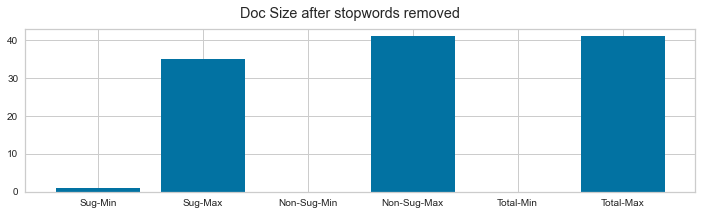

In [ ]:
names = ['Sug-Min', 'Sug-Max', 'Non-Sug-Min','Non-Sug-Max','Total-Min','Total-Max']
values = [(calculate_min_doc_size(suggestion_df['stop_words_removed'])), (calculate_max_doc_size(suggestion_df['stop_words_removed'])), (calculate_min_doc_size(non_suggestion_df['stop_words_removed'])),(calculate_max_doc_size(non_suggestion_df['stop_words_removed'])),(calculate_min_doc_size(trainingData['stop_words_removed'])),(calculate_max_doc_size(trainingData['stop_words_removed']))]

plt.figure(figsize=(12, 3))

plt.bar(names, values)
plt.suptitle('Doc Size after stopwords removed')
plt.show()

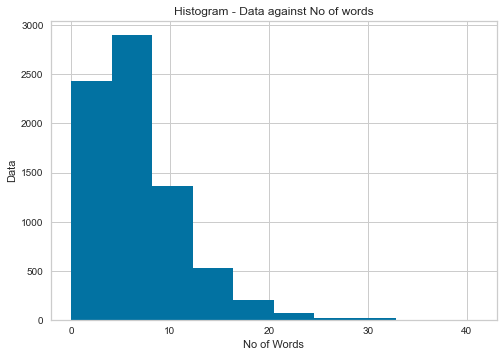

In [ ]:
trainingData_list =  trainingData['stop_words_removed']

words_no_list=[]
def no_of_words(txt):
    words_no_list.append(len(txt))

trainingData['stop_words_removed'].apply(lambda x : no_of_words(x))

plt.title('Histogram - Data against No of words')
plt.xlabel('No of Words')
plt.ylabel('Data')
plt.hist(words_no_list)
plt.show()

#### Lemmatization - Stopwords removed data

In [ ]:
# Annotate text tokens with POS tags
wnl = WordNetLemmatizer()
def pos_tag_text(text):
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    tokens = nltk.word_tokenize(text)
    tagged_text = nltk.pos_tag(tokens)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text
    
# Lemmatize text based on POS tags using Wordnet
def lemmatize_text(text):
    string_txt= ""
    for i in range(len(text)):
            string_txt+= text[i]+" "
    pos_tagged_text = pos_tag_text(string_txt)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ''.join(lemmatized_tokens)
    return lemmatized_tokens

In [ ]:
suggestion_df['stop_words_removed_lemmatized']=suggestion_df['stop_words_removed'].apply(lambda x : lemmatize_text(x))
non_suggestion_df['stop_words_removed_lemmatized']=non_suggestion_df['stop_words_removed'].apply(lambda x : lemmatize_text(x))
trainingData['stop_words_removed_lemmatized']=trainingData['stop_words_removed'].apply(lambda x : lemmatize_text(x))

testData['stop_words_removed_lemmatized']=testData['stop_words_removed'].apply(lambda x : lemmatize_text(x))

In [ ]:
suggestion_tokens_lemmatized =[]
suggestion_df['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,suggestion_tokens_lemmatized))
print("Total Suggestion tokens-stopwords removed:"+(str)(len(suggestion_tokens_lemmatized)))

unique_suggestion_tokens_lemmatized = set(suggestion_tokens_lemmatized)
print("Unique Suggestion tokens-stopwords removed and lemmatized:"+(str)(len(unique_suggestion_tokens_lemmatized)))

Total Suggestion tokens-stopwords removed:4006
Unique Suggestion tokens-stopwords removed and lemmatized:1418


In [ ]:
non_suggestion_tokens_lemmatized =[]
non_suggestion_df['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,non_suggestion_tokens_lemmatized))
print("Total Suggestion tokens-stopwords removed:"+(str)(len(non_suggestion_tokens_lemmatized)))

unique_non_suggestion_tokens_lemmatized = set(non_suggestion_tokens_lemmatized)
print("Unique non-Suggestion tokens-stopwords removed and lemmatized:"+(str)(len(unique_non_suggestion_tokens_lemmatized)))

Total Suggestion tokens-stopwords removed:49434
Unique non-Suggestion tokens-stopwords removed and lemmatized:5898


In [ ]:
combine_unique_tokens_lemmatized=reduce(operator.or_, [unique_suggestion_tokens_lemmatized, unique_non_suggestion_tokens_lemmatized])
print("Unique tokens-stopwords removed and lemmatized:"+(str)(len(combine_unique_tokens_lemmatized)))

Unique tokens-stopwords removed and lemmatized:6141


In [ ]:
print("Maximum doc-size after lemmatization (suggestion): "+(str)(calculate_max_doc_size(suggestion_df['stop_words_removed_lemmatized'])))
print("Minimum doc-size after lemmatization (suggestion): "+(str)(calculate_min_doc_size(suggestion_df['stop_words_removed_lemmatized'])))
print("\n")
print("Maximum doc-size after lemmatization (non-suggestion): "+(str)(calculate_max_doc_size(non_suggestion_df['stop_words_removed_lemmatized'])))
print("Minimum doc-size after lemmatization (non-suggestion): "+(str)(calculate_min_doc_size(non_suggestion_df['stop_words_removed_lemmatized'])))
print("\n")
print("Maximum doc-size after lemmatization (Total): "+(str)(calculate_max_doc_size(trainingData['stop_words_removed_lemmatized'])))
print("Minimum doc-size after lemmatization (Total): "+(str)(calculate_min_doc_size(trainingData['stop_words_removed_lemmatized'])))

Maximum doc-size after lemmatization (suggestion): 35
Minimum doc-size after lemmatization (suggestion): 1


Maximum doc-size after lemmatization (non-suggestion): 41
Minimum doc-size after lemmatization (non-suggestion): 0


Maximum doc-size after lemmatization (Total): 41
Minimum doc-size after lemmatization (Total): 0


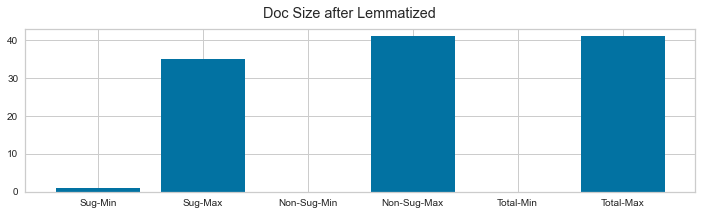

In [ ]:
names = ['Sug-Min', 'Sug-Max', 'Non-Sug-Min','Non-Sug-Max','Total-Min','Total-Max']
values = [(calculate_min_doc_size(suggestion_df['stop_words_removed_lemmatized'])), (calculate_max_doc_size(suggestion_df['stop_words_removed_lemmatized'])), (calculate_min_doc_size(non_suggestion_df['stop_words_removed_lemmatized'])),(calculate_max_doc_size(non_suggestion_df['stop_words_removed_lemmatized'])),(calculate_min_doc_size(trainingData['stop_words_removed_lemmatized'])),(calculate_max_doc_size(trainingData['stop_words_removed_lemmatized']))]

plt.figure(figsize=(12, 3))

plt.bar(names, values)
plt.suptitle('Doc Size after Lemmatized')
plt.show()

#### Stemming - Stopwords removed data

In [ ]:
#instantiate stemmer
stemmer = PorterStemmer()

In [ ]:
def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

In [ ]:
suggestion_df['stop_words_removed_stemmed']=suggestion_df['stop_words_removed'].apply(lambda x : word_stemmer(x))
non_suggestion_df['stop_words_removed_stemmed']=non_suggestion_df['stop_words_removed'].apply(lambda x : word_stemmer(x))
trainingData['stop_words_removed_stemmed']=trainingData['stop_words_removed'].apply(lambda x : word_stemmer(x))

In [ ]:
suggestion_tokens_stemmed =[]
suggestion_df['stop_words_removed_stemmed'].apply(lambda x : tokens_to_array(x,suggestion_tokens_stemmed))
print("Total Suggestion tokens stemmed-stopwords removed:"+(str)(len(suggestion_tokens_stemmed)))

unique_suggestion_tokens_stemmed = set(suggestion_tokens_stemmed)
print("Unique Suggestion tokens-stopwords removed and stemmed:"+(str)(len(unique_suggestion_tokens_stemmed)))

Total Suggestion tokens stemmed-stopwords removed:4002
Unique Suggestion tokens-stopwords removed and stemmed:1361


In [ ]:
non_suggestion_tokens_stemmed =[]
non_suggestion_df['stop_words_removed_stemmed'].apply(lambda x : tokens_to_array(x,non_suggestion_tokens_stemmed))
print("Total Non-Suggestion tokens stemmed-stopwords removed:"+(str)(len(non_suggestion_tokens_stemmed)))

unique_non_suggestion_tokens_stemmed = set(non_suggestion_tokens_stemmed)
print("Unique Non-Suggestion tokens-stopwords removed and stemmed:"+(str)(len(unique_non_suggestion_tokens_stemmed)))

Total Non-Suggestion tokens stemmed-stopwords removed:49369
Unique Non-Suggestion tokens-stopwords removed and stemmed:5233


In [ ]:
combine_unique_tokens_stemmed=reduce(operator.or_, [unique_suggestion_tokens_stemmed, unique_non_suggestion_tokens_stemmed])
print("Unique tokens-stopwords removed and stemmed:"+(str)(len(combine_unique_tokens_stemmed)))

Unique tokens-stopwords removed and stemmed:5437


In [ ]:
print("Maximum doc-size after stemming (suggestion): "+(str)(calculate_max_doc_size(suggestion_df['stop_words_removed_stemmed'])))
print("Minimum doc-size after stemming (suggestion): "+(str)(calculate_min_doc_size(suggestion_df['stop_words_removed_stemmed'])))

print("\n")
print("Maximum doc-size after stemming (non-suggestion): "+(str)(calculate_max_doc_size(non_suggestion_df['stop_words_removed_stemmed'])))
print("Minimum doc-size after stemming (non-suggestion): "+(str)(calculate_min_doc_size(non_suggestion_df['stop_words_removed_stemmed'])))

print("\n")
print("Maximum doc-size after stemming (Total): "+(str)(calculate_max_doc_size(trainingData['stop_words_removed_stemmed'])))
print("Minimum doc-size after stemming (Total): "+(str)(calculate_min_doc_size(trainingData['stop_words_removed_stemmed'])))

Maximum doc-size after stemming (suggestion): 35
Minimum doc-size after stemming (suggestion): 1


Maximum doc-size after stemming (non-suggestion): 41
Minimum doc-size after stemming (non-suggestion): 0


Maximum doc-size after stemming (Total): 41
Minimum doc-size after stemming (Total): 0


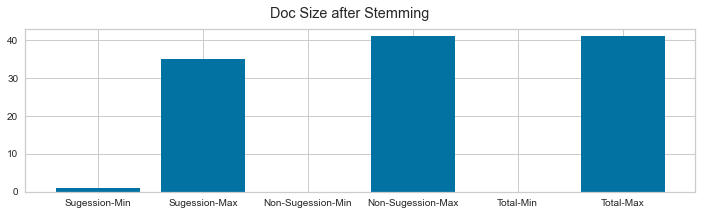

In [ ]:
names = ['Sugession-Min', 'Sugession-Max', 'Non-Sugession-Min','Non-Sugession-Max','Total-Min','Total-Max']
values = [(calculate_min_doc_size(suggestion_df['stop_words_removed_stemmed'])), (calculate_max_doc_size(suggestion_df['stop_words_removed_stemmed'])), (calculate_min_doc_size(non_suggestion_df['stop_words_removed_stemmed'])),(calculate_max_doc_size(non_suggestion_df['stop_words_removed_stemmed'])),(calculate_min_doc_size(trainingData['stop_words_removed_stemmed'])), (calculate_max_doc_size(trainingData['stop_words_removed_stemmed']))]

plt.figure(figsize=(12, 3))

plt.bar(names, values)
plt.suptitle('Doc Size after Stemming')
plt.show()

In [ ]:
trainingData.to_csv("cleaned_corpus.csv")
trainingData.head()

,hotel_name,reviews,label,reviews_fixed,tokenized_reviews,stop_words_removed,stop_words_removed_lemmatized,stop_words_removed_stemmed
0,berlin-hotel-190599-review-1.json_0,This hotel was very modern and sleek.,0,This hotel was very modern and sleek,"[this, hotel, was, very, modern, and, sleek]","[hotel, modern, sleek]","[hotel, modern, sleek]","[hotel, modern, sleek]"
1,berlin-hotel-190599-review-1.json_1,"Beautiful, well-laid out, albeiit small rooms.",0,Beautiful well laid out albeiit small rooms,"[beautiful, well, laid, out, albeiit, small, r...","[beautiful, well, laid, albeiit, small, rooms]","[beautiful, well, lay, albeiit, small, room]","[beauti, well, laid, albeiit, small, room]"
2,berlin-hotel-190599-review-1.json_2,Fantastic breakfast with an incredible selecti...,0,Fantastic breakfast with an incredible selecti...,"[fantastic, breakfast, with, an, incredible, s...","[fantastic, breakfast, incredible, selection, ...","[fantastic, breakfast, incredible, selection, ...","[fantast, breakfast, incred, select, meat, che..."
3,berlin-hotel-190599-review-1.json_3,the staff were uber-helpful.,0,the staff we are uber helpful,"[the, staff, we, are, uber, helpful]","[staff, uber, helpful]","[staff, uber, helpful]","[staff, uber, help]"
4,berlin-hotel-190599-review-1.json_4,Great location in front of a u-bahn stop.,0,Great location in front of bahn stop,"[great, location, in, front, of, bahn, stop]","[great, location, front, bahn, stop]","[great, location, front, bahn, stop]","[great, locat, front, bahn, stop]"


We used lemmatized data set to continue, because in stemming it gives only the root word but in lemmatization it checked with wordnet corpus and give the word, for this dataset it is good to use lemmatization rather than stemming

***Creating a bag-of-words and	TF-IDF representations of	the	posts	in	the dataset above and	using	two	relevant	supervised	learning algorithms	to	classify	future	posts	as	suggestions	or	non-suggestions.***

In [ ]:
# Get the normalized corpus
corpus_train =[]
corpus_suggestions=[]
corpus_non_suggestions=[]
corpus_test =[]

trainingData['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,corpus_train))
suggestion_df['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,corpus_suggestions))
non_suggestion_df['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,corpus_non_suggestions))
testData['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,corpus_test))

print("words in each corpus:\n\ncorpus_train:"+(str)(len(corpus_train))+"\ncorpus_suggestions:"+(str)(len(corpus_suggestions))+"\ncorpus_non_suggestions:"+(str)(len(corpus_non_suggestions)))

words in each corpus:

corpus_train:53440
corpus_suggestions:4006
corpus_non_suggestions:49434


In [ ]:
#countVectorizer
def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

#countVectorizer - bigrams
def bow_extractor_bi(corpus, ngram_range=(2,3)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


def tfidf_transformer(bow_matrix):
    transformer = TfidfTransformer(norm='l2',
                                   smooth_idf=True,
                                   use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix

# TfidfVectorizer
def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

# TfidfVectorizer-bigrams
def tfidf_extractor_bi(corpus, ngram_range=(2,3)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


# Two weighting schemes for combining word vectors in documents
# 1. averaging the word vectors
# 2. tf-idf weighting of word vectors
# Averaging word vectors of a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)  
    return feature_vector
 
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features) 

In [ ]:
# array of words to string
def array_to_str(arr,listx):
    text =""
    for i in range(len(arr)):
        text+=arr[i]+" "
    listx.append(text.strip())

training_final=[]
testing_final=[]
trainingData['stop_words_removed_lemmatized'].apply(lambda x : array_to_str(x,training_final))
testData['stop_words_removed_lemmatized'].apply(lambda x : array_to_str(x,testing_final))

0      None
1      None
2      None
3      None
4      None
       ... 
803    None
804    None
805    None
806    None
807    None
Name: stop_words_removed_lemmatized, Length: 808, dtype: object

In [ ]:
train_corpus, test_corpus, train_labels, test_labels = training_final,testing_final,trainingData['label'],testData['label']

# Bag of words (BoW) features
bow_vectorizer, bow_train_features = bow_extractor(train_corpus)  
bow_test_features = bow_vectorizer.transform(test_corpus) 

# tfidf features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_corpus)  
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)    

In [ ]:
# Define function to calculate the 4 common mertics
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(
                        accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print('Precision:', np.round(
                        precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('Recall:', np.round(
                        recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('F1 Score:', np.round(
                        f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)
    return predictions    

In [ ]:
mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge')

print("==============Multinomial Naive Bayes with bag of word===============")
# Multinomial Naive Bayes with bag of words features
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

print("\n============Support Vector Machine with bag of words===============")
# Support Vector Machine with bag of words features
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

print("\n===============Multinomial Naive Bayes with tfidf==================")
# Multinomial Naive Bayes with tfidf features                                           
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

print("\n=================Support Vector Machine with tfidf=================")
# Support Vector Machine with tfidf features
svm_tfidf_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

==============Multinomial Naive Bayes with bag of word===============
Accuracy: 0.52
Precision: 0.76
Recall: 0.52
F1 Score: 0.38

============Support Vector Machine with bag of words===============
Accuracy: 0.65
Precision: 0.79
Recall: 0.65
F1 Score: 0.6

===============Multinomial Naive Bayes with tfidf==================
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.33

=================Support Vector Machine with tfidf=================
Accuracy: 0.55
Precision: 0.76
Recall: 0.55
F1 Score: 0.44


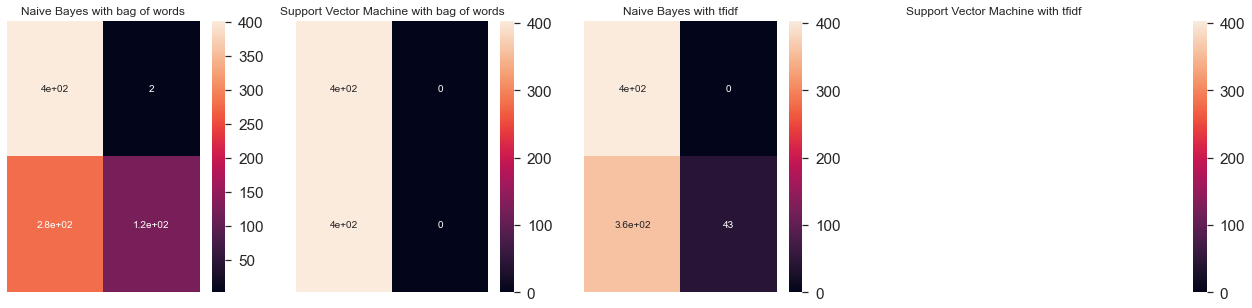

In [ ]:
cm_nb_bow = metrics.confusion_matrix(test_labels, mnb_bow_predictions)
plt.figure(figsize=(25,5))
sns.set(font_scale=1.4)
sns.heatmap(cm_nb_bow, annot=True, annot_kws={"size": 10})
plt.subplot(1,5,1)
plt.title("Naive Bayes with bag of words", fontsize = 12)
plt.axis("off")

cm_svm_bow = metrics.confusion_matrix(test_labels, svm_bow_predictions)
sns.set(font_scale=1.4)
sns.heatmap(cm_svm_bow, annot=True, annot_kws={"size": 10})
plt.subplot(1,5,2)
plt.title("Support Vector Machine with bag of words", fontsize = 12)
plt.axis("off")

cm_nb_tf = metrics.confusion_matrix(test_labels, mnb_tfidf_predictions)
sns.set(font_scale=1.4)
sns.heatmap(cm_nb_tf, annot=True, annot_kws={"size": 10})
plt.subplot(1,5,3)
plt.title("Naive Bayes with tfidf", fontsize = 12)
plt.axis("off")

cm_svm_tf = metrics.confusion_matrix(test_labels, svm_tfidf_predictions)
sns.set(font_scale=1.4)
sns.heatmap(cm_svm_tf, annot=True, annot_kws={"size": 10})
plt.subplot(1,5,4)
plt.title("Support Vector Machine with tfidf", fontsize = 12)
plt.axis("off")

plt.show()  

***Trying to improve the performace by word-frame count increasing and trying out new algorithms.***

***Change the minimum data frame lentgh***

In [ ]:
#countVectorizer
min_ = 5
def bow_extractor_min(corpus, ngram_range=(1,1),min_df=min_):
    vectorizer = CountVectorizer(min_df=min_, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

#countVectorizer - bigrams
def bow_extractor_bi_min(corpus, ngram_range=(2,3),min_df=min_):
    vectorizer = CountVectorizer(min_df=min_, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

# TfidfVectorizer
def tfidf_extractor_min(corpus, ngram_range=(1,1),min_df=min_):
    vectorizer = TfidfVectorizer(min_df=min_, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [ ]:
# Bag of words (BoW) features
bow_vectorizer_min, bow_train_features_min = bow_extractor_min(train_corpus)  
bow_test_features_min = bow_vectorizer_min.transform(test_corpus) 

# tfidf features
tfidf_vectorizer_min, tfidf_train_features_min = tfidf_extractor_min(train_corpus)  
tfidf_test_features_min = tfidf_vectorizer_min.transform(test_corpus)  

In [ ]:
print("==============Multinomial Naive Bayes with bag of word df 5===============")
# Multinomial Naive Bayes with bag of words features
mnb_bow_predictions_min = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features_min,
                                           train_labels=train_labels,
                                           test_features=bow_test_features_min,
                                           test_labels=test_labels)

print("\n============Support Vector Machine with bag of words df 5===============")
# Support Vector Machine with bag of words features
svm_bow_predictions_min = train_predict_evaluate_model(classifier=svm,
                                           train_features=bow_train_features_min,
                                           train_labels=train_labels,
                                           test_features=bow_test_features_min,
                                           test_labels=test_labels)

print("\n===============Multinomial Naive Bayes with tfidf df 5==================")
# Multinomial Naive Bayes with tfidf features                                           
mnb_tfidf_predictions_min = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features_min,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features_min,
                                           test_labels=test_labels)

print("\n=================Support Vector Machine with tfidf df 5=================")
# Support Vector Machine with tfidf features
svm_tfidf_predictions_min = train_predict_evaluate_model(classifier=svm,
                                           train_features=tfidf_train_features_min,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features_min,
                                           test_labels=test_labels)

==============Multinomial Naive Bayes with bag of word df 5===============
Accuracy: 0.6
Precision: 0.77
Recall: 0.6
F1 Score: 0.52

============Support Vector Machine with bag of words df 5===============
Accuracy: 0.65
Precision: 0.79
Recall: 0.65
F1 Score: 0.6

===============Multinomial Naive Bayes with tfidf df 5==================
Accuracy: 0.5
Precision: 0.75
Recall: 0.5
F1 Score: 0.34

=================Support Vector Machine with tfidf df 5=================
Accuracy: 0.56
Precision: 0.77
Recall: 0.56
F1 Score: 0.46


incresing the dataframe will result in few improvement in accuracy because it will remove the words that not occuring more than 5, but if this is applied to a small data set it will lead to overfitting<br>

#### Trying new classifiers

In [ ]:
# tokens to array of arrays
def tokens_to_arrayofarrays(arr,words):
    temp = []
    for i in range(len(arr)):
        if(len(arr[i])>0):
            temp.append(arr[i])
    arr.append(temp)

word2vecCorpus=[]
trainingData['stop_words_removed_lemmatized'].apply(lambda x : tokens_to_array(x,word2vecCorpus))
# build word2vec model                   
model = gensim.models.Word2Vec(word2vecCorpus,
                               window=100,
                               min_count=5,
                               sample=1e-3)    

print("=============Average Word Vector===========")
# averaged word vector features
avg_wv_train_features = averaged_word_vectorizer(corpus=train_corpus,
                                                 model=model.wv,
                                                 num_features=100)                   
avg_wv_test_features = averaged_word_vectorizer(corpus=test_corpus,
                                                model=model.wv,
                                                num_features=100)     

# Support Vector Machine with averaged word vector features
svm_avgwv_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=avg_wv_train_features,
                                           train_labels=train_labels,
                                           test_features=avg_wv_test_features,
                                           test_labels=test_labels)


=============Average Word Vector===========
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.33


In [ ]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')
Log_Reg.fit(bow_train_features,train_labels)

prediction_bow = Log_Reg.predict_proba(bow_test_features)
prediction_bow = prediction_bow[:,1]>=0.5

# converting the results to integer type
prediction_int = prediction_bow.astype(np.int)

# calculating scores
print("=================LogisiticRegression with bow=================")
get_metrics(test_labels,prediction_int)

=================LogisiticRegression with bow=================
Accuracy: 0.6
Precision: 0.78
Recall: 0.6
F1 Score: 0.52


In [ ]:
Log_Reg_tfidf = LogisticRegression(random_state=0,solver='lbfgs')
Log_Reg_tfidf.fit(tfidf_train_features,train_labels)

prediction_tfidf = Log_Reg.predict_proba(tfidf_test_features)
prediction_tfidf = prediction_tfidf[:,1]>=0.5

# converting the results to integer type
prediction_tfidf = prediction_tfidf.astype(np.int)

# calculating scores
print("=================LogisiticRegression with tfidf=================")
get_metrics(test_labels,prediction_tfidf)

=================LogisiticRegression with tfidf=================
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.33


In [ ]:
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(bow_train_features,train_labels)

xgb = model_bow.predict_proba(bow_test_features)
xgb=xgb[:,1]>=0.5

# converting the results to integer type
xgb_int=xgb.astype(np.int)

# calculating scores
print("=================XGBoost with bow=================")
get_metrics(test_labels,xgb_int)

[21:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
=================XGBoost with bow=================
Accuracy: 0.62
Precision: 0.77
Recall: 0.62
F1 Score: 0.56


In [ ]:
from xgboost import XGBClassifier
model_tfidf = XGBClassifier(random_state=22,learning_rate=0.9)
model_tfidf.fit(tfidf_train_features,train_labels)

xgb = model_tfidf.predict_proba(tfidf_test_features)
xgb=xgb[:,1]>=0.5

# converting the results to integer type
xgb_int=xgb.astype(np.int)

# calculating scores
print("=================XGBoost with tfidf=================")
get_metrics(test_labels,xgb_int)

[21:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
=================XGBoost with tfidf=================
Accuracy: 0.6
Precision: 0.76
Recall: 0.6
F1 Score: 0.53


In [ ]:
# Bag of words (BoW) features
bow_vectorizer_bi, bow_train_features_bi = bow_extractor_bi(train_corpus)  
bow_test_features_bi = bow_vectorizer_bi.transform(test_corpus) 

# TFIDF features
tfidf_vectorizer_bi, tfidf_train_features_bi = tfidf_extractor_bi(train_corpus)  
tfidf_test_features_bi = tfidf_vectorizer_bi.transform(test_corpus)   

In [ ]:
print("===================Multinomial Naive Bayes with bag of words bi-grams===================")
# Multinomial Naive Bayes with bag of words features
mnb_bow_predictions_ = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features_bi,
                                           train_labels=train_labels,
                                           test_features=bow_test_features_bi,
                                           test_labels=test_labels)

print("\n============Support Vector Machine with bag of words bi-grams==============")
# Support Vector Machine with bag of words features
svm_bow_predictions_ = train_predict_evaluate_model(classifier=svm,
                                           train_features=bow_train_features_bi,
                                           train_labels=train_labels,
                                           test_features=bow_test_features_bi,
                                           test_labels=test_labels)

print("\n===============Multinomial Naive Bayes with tfidf bi-grams==================")
# Multinomial Naive Bayes with tfidf features                                           
mnb_tfidf_predictions_ = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features_bi,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features_bi,
                                           test_labels=test_labels)

print("\n=================Support Vector Machine with tfidf bi-grams=================")
# Support Vector Machine with tfidf features
svm_tfidf_predictions_ = train_predict_evaluate_model(classifier=svm,
                                           train_features=tfidf_train_features_bi,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features_bi,
                                           test_labels=test_labels)

===================Multinomial Naive Bayes with bag of words bi-grams===================
Accuracy: 0.54
Precision: 0.76
Recall: 0.54
F1 Score: 0.41

============Support Vector Machine with bag of words bi-grams==============
Accuracy: 0.56
Precision: 0.77
Recall: 0.56
F1 Score: 0.45

===============Multinomial Naive Bayes with tfidf bi-grams==================
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.33

=================Support Vector Machine with tfidf bi-grams=================
Accuracy: 0.56
Precision: 0.77
Recall: 0.56
F1 Score: 0.46


In [ ]:
# create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

Normalized confusion matrix
[[0.99 0.01]
 [0.79 0.21]]


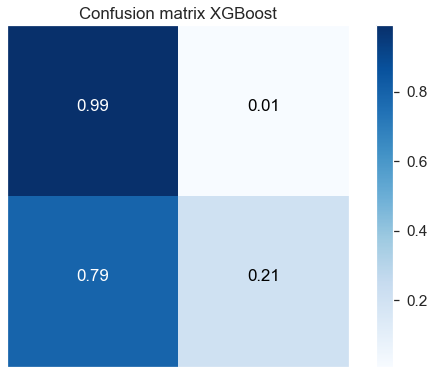

In [ ]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(test_labels, xgb_int)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[],normalize=True,
                      title='Confusion matrix XGBoost')

***Trying to use unsupervised algorims to check where it is having good clustering or not.***

In [ ]:
# This method used to build the feature matrix
def build_feature_matrix(documents, feature_type='frequency',
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0):
    feature_type = feature_type.lower().strip()  
    if feature_type == 'truncatedsvd':
        vectorizer = TruncatedSVD()
        
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, 
                                     ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    return vectorizer, feature_matrix


# The ‘elbow method’ in a sum of squared errors plot used to decide the clusters
def find_optimal_clusters_using_elbow(data, max_k):
    iters = range(2, max_k+1)
    
    sum_squared_errors = []
    for num_cluster in iters:
        sum_squared_errors.append(KMeans(n_clusters=num_cluster).fit(data).inertia_)
    
    optimal_clusters = np.argmin(sum_squared_errors) # As argmin return the index of minimum loss. 
    plt.plot(iters, sum_squared_errors)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Errors')
    plt.title('Elbow Method for Optimal Cluster')
    xy = (optimal_clusters, min(sum_squared_errors))
    plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
    plt.show()
        
# The Silhouette Coefficient used to decide the clusters
def find_optimal_clusters_using_silhouette(data, number_of_clusters):
    silhouette_score_values=list()

    clusters = range(2, number_of_clusters+1)

    for i in clusters:

        clusterer = KMeans(n_clusters=i, max_iter=10000, random_state=42)    
        clusterer.fit(data)
        labels= clusterer.predict(data)
        silhouette_score_values.append(silhouette_score(data,labels ,metric='cosine', 
                                                        sample_size=None, random_state=None))

    plt.plot(clusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()

# The Silhouette Coefficient used to decide the clusters
def find_optimal_clusters_using_silhouette_yellowbrick(data, number_of_clusters):

    clusters = range(2, number_of_clusters+1)
    # Instantiate a scikit-learn K-Means model
    model = KMeans( max_iter=10000, random_state=0)

    # Instantiate the KElbowVisualizer with the number of clusters and the metric 
    visualizer = KElbowVisualizer(model, cluster_counts=(clusters), metric='silhouette', timings=False)

    # Fit the data and visualize
    visualizer.fit(data)    
    visualizer.poof()
        
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000, random_state=0)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters


# Generic function to extract details of the clusters we get (from each of our algorithms)
def get_cluster_data(clustering_obj, cleaned_corpus, 
                     feature_names, num_clusters,
                     topn_features=20):

    cluster_details = {}  
    # Get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # Get key features for each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        words = cleaned_corpus[cleaned_corpus.iloc[:, 8] == cluster_num].iloc[:, 6].values.tolist()
        cluster_details[cluster_num]['words'] = words
    
    return cluster_details
        
       
# Simple function to print the data we extracted with the above function
def print_cluster_data(cluster_data, record_count = 10):
    # Print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        print('Words in this cluster:')
        print(([[' '.join(i)] for i in cluster_details['words'][:record_count]]))
        print('='*40)

In [ ]:
suggestion_corpus =[]
suggestion_df['stop_words_removed_lemmatized'].apply(lambda x : array_to_str(x,suggestion_corpus))

13      None
17      None
35      None
41      None
71      None
        ... 
7497    None
7501    None
7520    None
7529    None
7533    None
Name: stop_words_removed_lemmatized, Length: 448, dtype: object

#### Cluster selection with BoW using CountVectorizer

---------------------------------
Optimal clusters using silhouette
---------------------------------


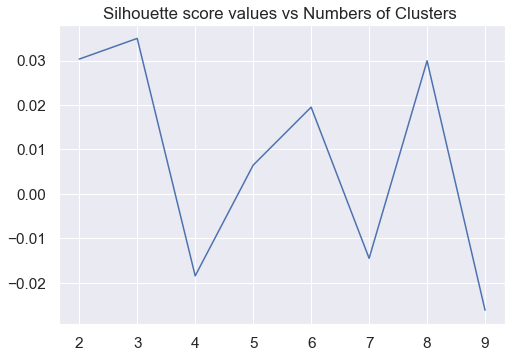

-----------------------------------
Optimal clusters using elbow method
----------------------------------


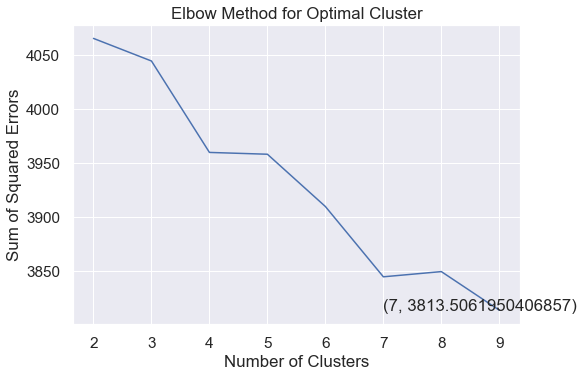

---------------------------------------------
Optimal clusters using silhouette yellowbrick
---------------------------------------------


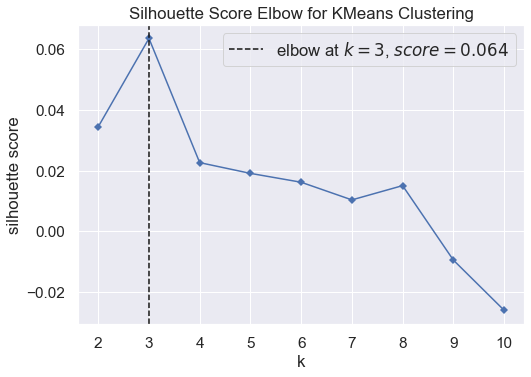

In [ ]:
train_corpus_unsupervised = suggestion_corpus
# Creating the bag of words using CountVectorizer
vectozierWords, feature_matrix =  build_feature_matrix(train_corpus_unsupervised,
                                                  feature_type='frequency')
# Get the names of the features
feature_names = vectozierWords.get_feature_names()

# Identify the optimal clusters using silhouette for counter-vectorizer
print('---------------------------------')
print('Optimal clusters using silhouette')
print('---------------------------------')
find_optimal_clusters_using_silhouette(feature_matrix, 9)
# Identify the optimal clusters using elbow for counter-vectorizer
print('-----------------------------------')
print('Optimal clusters using elbow method')
print('----------------------------------')
find_optimal_clusters_using_elbow(feature_matrix, 9)
# Identify the optimal clusters using silhouette yellowbrick for counter-vectorizer
print('---------------------------------------------')
print('Optimal clusters using silhouette yellowbrick')
print('---------------------------------------------')
find_optimal_clusters_using_silhouette_yellowbrick(feature_matrix, 9)

#### Explanation for cluster selection in count vecotrizer
According to the above intrinsic evaluation techniques, Elbow has a better curve on 3,and 8 whereas the silhouette represents the maximum value for cluster 3 and 8 . But, the silhouette has better optimal value for 3. Therefore, 3 has been identified as the best cluster using  counter vectorizer and when applied that got some messy clusters so applied the next best value which is 8 and got some good clustering.The 3 clusters didn't work due to the features in the dataset are large and the no of data in the data are small.

In [ ]:
count_num_clusters =8

# Call the above function to get clusters and assign the cluster labels
count_vect_km_obj, count_vect_clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=count_num_clusters)

suggestion_df['count_vect_clusters']=count_vect_clusters

# Analyse the k-means clustering data
cluster_data =  get_cluster_data(clustering_obj=count_vect_km_obj,
                                 cleaned_corpus=suggestion_df,
                                 feature_names=vectozierWords.get_feature_names(),
                                 num_clusters=count_num_clusters,
                                 topn_features=10)         

# Print the detailed clustering analysis results
print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['key', 'front', 'desk', 'room', 'make', 'habit', 'one', 'oh', 'available', 'someone']
Words in this cluster:
[['oh like keep key front desk one key available per room share someone different itinerary make habit drop key front desk']]
Cluster 1 details:
--------------------
Key features: ['room', 'hotel', 'floor', 'get', 'one', 'small', 'stay', 'would', 'ask', 'recommend']
Words in this cluster:
[['end sure specify room back hotel'], ['wake early morning fire local bus service courtyard face room essential unless industrial strength earplug room small ill conceive'], ['room big bath lovely watch tile floor shower'], ['high breakfast price ever see would nice room beverage station coffee maker like one usually find westins'], ['avoid room clear photograph web site'], ['room need upgrade badly view roof good clean'], ['hilton stay executive floor great lounge get room overlook gendarmenmarkt beautiful day night'], ['another comfortab

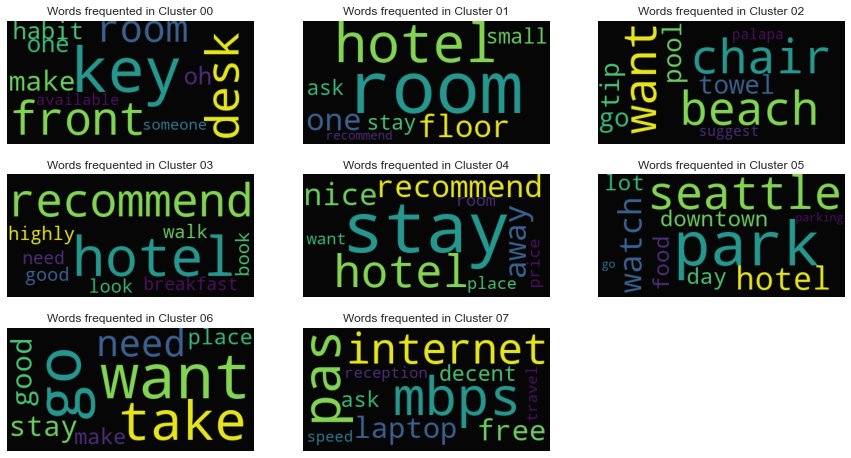

In [ ]:
content = cluster_data[0]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.figure(figsize = (15,8))
plt.subplot(3,3,1)
plt.axis("off")
plt.title("Words frequented in Cluster 00", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[1]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,2)
plt.axis("off")
plt.title("Words frequented in Cluster 01", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[2]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,3)
plt.axis("off")
plt.title("Words frequented in Cluster 02", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[3]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,4)
plt.axis("off")
plt.title("Words frequented in Cluster 03", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[4]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,5)
plt.axis("off")
plt.title("Words frequented in Cluster 04", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[5]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,6)
plt.axis("off")
plt.title("Words frequented in Cluster 05", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[6]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,7)
plt.axis("off")
plt.title("Words frequented in Cluster 06", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[7]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,8)
plt.axis("off")
plt.title("Words frequented in Cluster 07", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

plt.show()

#### Cluster selection with TF-IDF vectorizer

---------------------------------
Optimal clusters using silhouette
---------------------------------


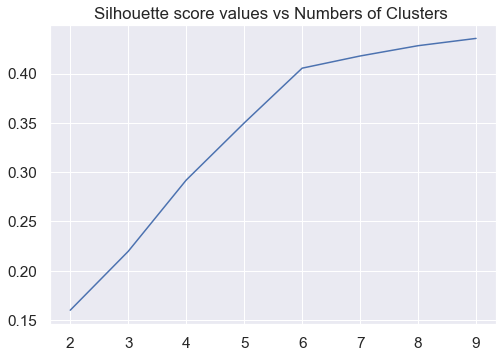

-----------------------------------
Optimal clusters using elbow method
-----------------------------------


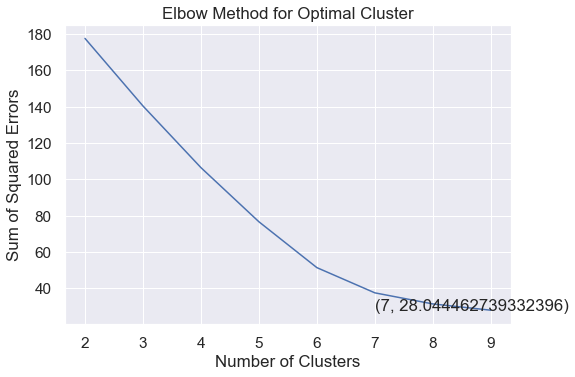

---------------------------------------------
Optimal clusters using silhouette yellowbrick
---------------------------------------------


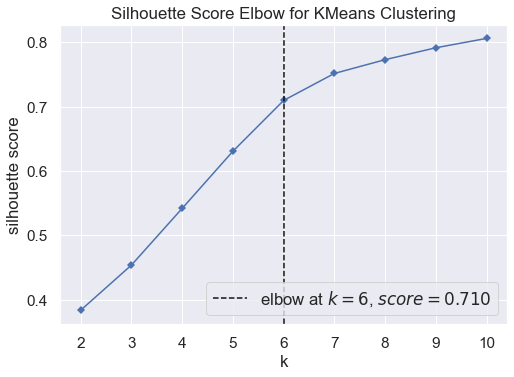

In [ ]:
# Create bag of words using the TF-IDF vectorizer
tfidf_vectorizer, tfidf_feature_matrix =  build_feature_matrix(train_corpus_unsupervised,
                                                      feature_type='tfidf',
                                                      min_df=0.10, max_df=0.88,
                                                      ngram_range=(1, 1))

# Identify the optimal clusters using silhouette for tfidf-vectorizer
print('---------------------------------')
print('Optimal clusters using silhouette')
print('---------------------------------')
find_optimal_clusters_using_silhouette(tfidf_feature_matrix, 9)

# Identify the optimal clusters using elbow for tfidf-vectorizer
print('-----------------------------------')
print('Optimal clusters using elbow method')
print('-----------------------------------')
find_optimal_clusters_using_elbow(tfidf_feature_matrix, 9)

# Identify the optimal clusters using silhouette yellowbrick for tfidf-vectorizer
print('---------------------------------------------')
print('Optimal clusters using silhouette yellowbrick')
print('---------------------------------------------')
find_optimal_clusters_using_silhouette_yellowbrick(tfidf_feature_matrix, 9)


<strong>Explanation for cluster selection in count vecotrizer</strong><br>
According to the above intrinsic evaluation techniques, Elbow has a better curve on 6 and also the silhouette represents the maximum value for cluster 6.  According to the yellow-brick library, an optimum cluster is 6. Therefore, 6 has been identified as the best cluster using TFIDF Unigram.

In [ ]:
tf_idf_uni_num_clusters =6
# Call the above function to get clusters and assign the cluster labels to the movies
tf_idf_uni_km_obj, tf_idf_uni_clusters = k_means(feature_matrix=tfidf_feature_matrix,
                           num_clusters=tf_idf_uni_num_clusters)

suggestion_df['count_vect_clusters']=tf_idf_uni_clusters

# Analyse the k-means clustering data
tfidf_uni_cluster_data =  get_cluster_data(clustering_obj=tf_idf_uni_km_obj,
                                 cleaned_corpus=suggestion_df,
                                 feature_names=tfidf_vectorizer.get_feature_names(),
                                 num_clusters=tf_idf_uni_num_clusters,
                                 topn_features=10)

# Print the detailed clustering analysis results
print_cluster_data(tfidf_uni_cluster_data, record_count = 20)

Cluster 0 details:
--------------------
Key features: ['would', 'stay', 'room', 'recommend', 'hotel', 'go']
Words in this cluster:
[['expect disappointed'], ['chair upholstery need clean'], ['eat breakfast restaurant costly'], ['walk block away get muffin coffee egg sandwich euro'], ['look famous berlin nightlife look elsewhere'], ['take sewer system put gdr need replace'], ['anyone look something little bit special look elsewhere'], ['may advise try another address'], ['bathroom urgent need remodelling exist one date back 60'], ['well avoid bar'], ['serve drink upon request lobby well ask'], ['bit pricey 19 euro since decent breakfest kaffee berlin'], ['recommand kaffee einstein'], ['must use risk break leg'], ['shop around newt get best deal'], ['definitely avoid travel easyjet weekend late evening'], ['one thing want visit bundestag good idea book tour english advance'], ['bathroom tire need refurbishment'], ['sure pick umbrella free concierge anticipate rain sightseeing'], ['might 

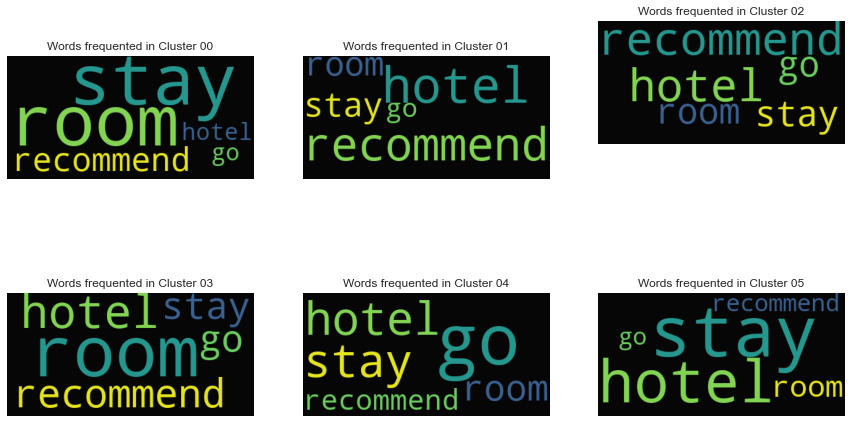

In [ ]:
content = tfidf_uni_cluster_data[0]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.figure(figsize = (15,8))
plt.subplot(2,3,1)
plt.axis("off")
plt.title("Words frequented in Cluster 00", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = tfidf_uni_cluster_data[1]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(2,3,2)
plt.axis("off")
plt.title("Words frequented in Cluster 01", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = tfidf_uni_cluster_data[2]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,3)
plt.axis("off")
plt.title("Words frequented in Cluster 02", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = tfidf_uni_cluster_data[3]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(2,3,4)
plt.axis("off")
plt.title("Words frequented in Cluster 03", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = tfidf_uni_cluster_data[4]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(2,3,5)
plt.axis("off")
plt.title("Words frequented in Cluster 04", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = tfidf_uni_cluster_data[5]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(2,3,6)
plt.axis("off")
plt.title("Words frequented in Cluster 05", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)


plt.show()

---------------------------------
Optimal clusters using silhouette
---------------------------------


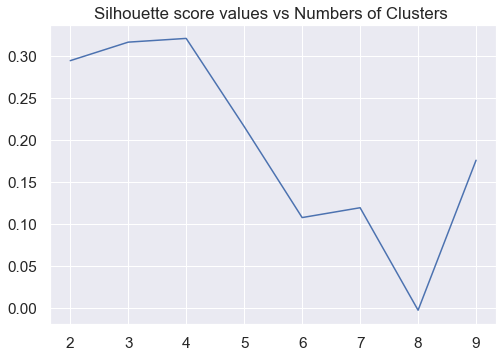

-----------------------------------
Optimal clusters using elbow method
-----------------------------------


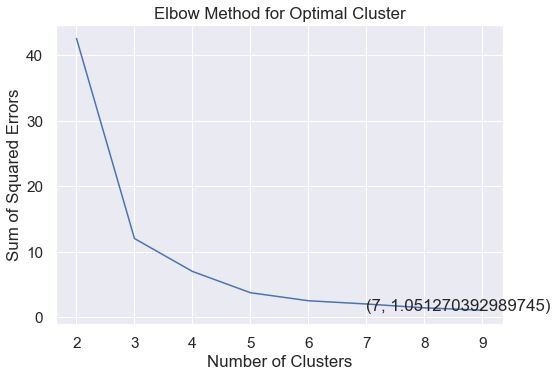

---------------------------------------------
Optimal clusters using silhouette yellowbrick
---------------------------------------------


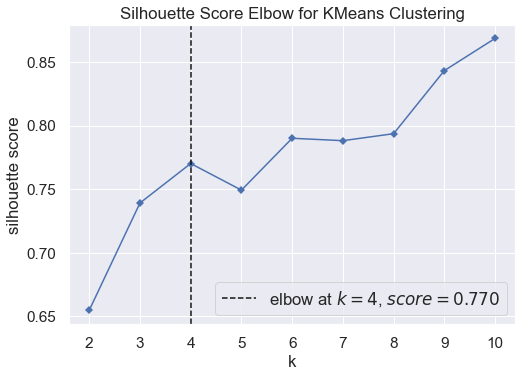

In [ ]:
# Create bag of words using the svd vectorizer 
svd_vectorizer_uni_grams, svd_uni_grams_feature_matrix =  build_feature_matrix(tfidf_feature_matrix,
                                                      feature_type='truncatedsvd')
# Identify the optimal clusters using silhouette for svd-vectorizer 
print('---------------------------------')
print('Optimal clusters using silhouette')
print('---------------------------------')
find_optimal_clusters_using_silhouette(svd_uni_grams_feature_matrix, 9)

# Identify the optimal clusters using elbow for svd-vectorizer 
print('-----------------------------------')
print('Optimal clusters using elbow method')
print('-----------------------------------')
find_optimal_clusters_using_elbow(svd_uni_grams_feature_matrix, 9)

# Identify the optimal clusters using silhouette yellowbrick for svd-vectorizer 
print('---------------------------------------------')
print('Optimal clusters using silhouette yellowbrick')
print('---------------------------------------------')
find_optimal_clusters_using_silhouette_yellowbrick(svd_uni_grams_feature_matrix, 8)

In [ ]:
svd_num_clusters = 3
# Call the above function to get clusters and assign the cluster labels to the movies
svd_km_obj, svd_clusters = k_means(feature_matrix=svd_uni_grams_feature_matrix,
                           num_clusters=svd_num_clusters)

weights =  np.dot(svd_km_obj.cluster_centers_, svd_vectorizer_uni_grams.components_)

weights.shape
features = tfidf_vectorizer.get_feature_names()
weights = np.abs(weights)

for i in range(svd_km_obj.n_clusters):
    top5 = np.argsort(weights[i])[:5]
    print([features[j] for j in top5], weights[i, top5])
suggestion_df['count_vect_clusters'] = svd_clusters

# Analyse the k-means clustering data
svd_cluster_data =  get_cluster_data(clustering_obj=svd_km_obj,
                                 cleaned_corpus=suggestion_df,
                                 feature_names=features,
                                 num_clusters=svd_num_clusters,
                                 topn_features=10)         

# Print the detailed clustering analysis results
print_cluster_data(svd_cluster_data) 

['room', 'go', 'stay', 'would', 'recommend'] [0.   0.01 0.01 0.02 0.02]
['room', 'go', 'stay', 'would', 'recommend'] [0.03 0.1  0.16 0.25 0.29]
['go', 'recommend', 'would', 'hotel', 'stay'] [0.02 0.04 0.07 0.08 0.12]
Cluster 0 details:
--------------------
Key features: ['go', 'hotel']
Words in this cluster:
[['general tip need use internet whilst berlin look easy internet cafe go huge one kurfurstendam'], ['expect disappointed'], ['desk staff need go waldorf class manner'], ['chair upholstery need clean'], ['eat breakfast restaurant costly'], ['walk block away get muffin coffee egg sandwich euro'], ['look famous berlin nightlife look elsewhere'], ['chance go brand new radisson hyatt marriott adlon'], ['get great rate per night like use voucher system ok otherwise stay elsewhere'], ['go picture starwood internet site']]
Cluster 1 details:
--------------------
Key features: ['go', 'hotel']
Words in this cluster:
[['look around area another hotel'], ['even benefit would recommend stay ho

According to the above identification, the optimum of the clusters will be 8. Because during CounterVectorizer and TFIDF Unigrams, optimum clusters have been identified as 3,8 and 6. But after analyzing the features in the clusters they are not clearly clustering in to a category. Whereas Truncated SVD is shown as 4. After looking at the dataset, identified as some of the top keywords not matched properly with dataset when compares to count vectorizer and TFIDF.

#### Gensim topic modelling

In [ ]:
#create a corpus
corpus_gensim =suggestion_df.iloc[:,6]
id2word = corpora.Dictionary(corpus_gensim)

corpus = [id2word.doc2bow(text) for text in corpus_gensim]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=corpus_gensim, start=2, limit=20, step=2)

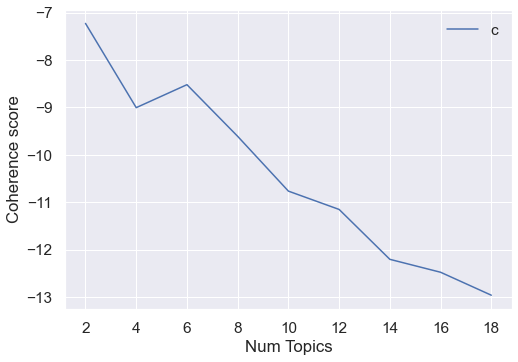

In [ ]:
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -7.23
Num Topics = 4  has Coherence Value of -9.0058
Num Topics = 6  has Coherence Value of -8.5216
Num Topics = 8  has Coherence Value of -9.6105
Num Topics = 10  has Coherence Value of -10.7653
Num Topics = 12  has Coherence Value of -11.1516
Num Topics = 14  has Coherence Value of -12.2032
Num Topics = 16  has Coherence Value of -12.4757
Num Topics = 18  has Coherence Value of -12.9596


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.Here We can use 12 Topics

In [ ]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.039*"hotel" + 0.027*"room" + 0.013*"get" + 0.012*"look" + 0.012*"recommend" + 0.012*"would" + 0.012*"stay" + 0.012*"breakfast" + 0.010*"advise" + 0.010*"walk"'), (1, '0.027*"hotel" + 0.023*"would" + 0.023*"room" + 0.017*"recommend" + 0.015*"floor" + 0.013*"stay" + 0.011*"get" + 0.010*"look" + 0.008*"city" + 0.008*"great"'), (2, '0.030*"would" + 0.023*"stay" + 0.018*"recommend" + 0.016*"breakfast" + 0.013*"good" + 0.013*"hotel" + 0.010*"metro" + 0.009*"get" + 0.008*"advise" + 0.008*"one"'), (3, '0.015*"take" + 0.014*"tip" + 0.014*"go" + 0.013*"need" + 0.011*"resort" + 0.010*"day" + 0.010*"good" + 0.009*"think" + 0.009*"rent" + 0.009*"want"'), (4, '0.023*"room" + 0.018*"hotel" + 0.015*"go" + 0.010*"little" + 0.010*"bed" + 0.010*"want" + 0.010*"one" + 0.008*"key" + 0.008*"also" + 0.008*"service"'), (5, '0.028*"stay" + 0.022*"hotel" + 0.020*"want" + 0.019*"room" + 0.018*"make" + 0.014*"get" + 0.014*"go" + 0.010*"sure" + 0.009*"need" + 0.008*"book"'), (6, '0.051*"recommend" + 0.036*

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=corpus_gensim, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.666447413458725

Coherence Score:  -11.151616239696061


In [ ]:
suggestion_original_reviews=suggestion_df['reviews'].tolist()
suggestion_original_cleaned=[]
suggestion_df['stop_words_removed_lemmatized'].apply(lambda x:array_to_str(x,suggestion_original_cleaned))

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        aspects =[]
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            val = False
            if j==0: #j<3 for prominent topics 3
#                 if(len(aspects)<3):
#                     if(topic_num not in aspects):
#                         aspects.append(topic_num)
#                     if(j==2):
                aspects.append(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([aspects, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(suggestion_original_reviews)
    cleaned = pd.Series(suggestion_original_cleaned)
    sent_topics_df = pd.concat([sent_topics_df, contents,cleaned], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Format
df_dominant_topic_12 = df_topic_sents_keywords.reset_index()
df_dominant_topic_12.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','Cleaned Data']

# Show
print(df_dominant_topic_12.shape)
df_dominant_topic_12.to_csv('./clustered_data.csv', encoding='utf-8')
df_dominant_topic_12.head()

(448, 6)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Cleaned Data
0,0,[11],0.8690,"hotel, room, get, one, stay, remember, water, ...","If you do end up here, be sure to specify a ro...",end sure specify room back hotel
1,1,[9],0.9542,"room, service, staff, book, unless, place, nee...",and I was woken by the early morning firing up...,wake early morning fire local bus service cour...
2,2,[4],0.9427,"room, hotel, go, little, bed, want, one, key, ...","As a general tip, if you need to use the inter...",general tip need use internet whilst berlin lo...
3,3,[9],0.6944,"room, service, staff, book, unless, place, nee...","If you expect no more than that, you won't be ...",expect disappointed
4,4,[1],0.8981,"hotel, would, room, recommend, floor, stay, ge...","Room was big, bath was lovely, but watch out f...",room big bath lovely watch tile floor shower


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.056477 -0.035803       1        1  11.647892
1     -0.053682  0.087595       2        1  11.110542
5     -0.015230 -0.044746       3        1   9.842429
7     -0.022549 -0.050352       4        1   9.469817
6     -0.099975  0.045195       5        1   9.185592
3      0.081389 -0.037266       6        1   8.023900
10     0.076611  0.118475       7        1   7.345201
2     -0.097503 -0.053306       8        1   7.252160
4      0.065779 -0.061130       9        1   6.983252
11     0.043087 -0.042499      10        1   6.900587
9      0.079679  0.000945      11        1   6.574868
8     -0.001128  0.072892      12        1   5.663760, topic_info=          Term       Freq      Total Category  logprob  loglift
93   recommend  53.000000  53.000000  Default  30.0000  30.0000
131     highly  17.000000  17.000000  Default  29.0000  29.0000
82       would  53.000000  53.000000  Default  28.0000  28.0000
3         room  68.000000  68.000000  Default  27.0000  27.0000
41       floor  14.000000  14.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
27          go   1.352606  35.303984  Topic12  -5.1224  -0.3909
94        stay   1.352395  51.038567  Topic12  -5.1226  -0.7596
161        ask   1.015413  10.916340  Topic12  -5.4092   0.4961
132     really   0.999402  11.011100  Topic12  -5.4251   0.4716
31        look   1.106897  20.944133  Topic12  -5.3229  -0.0692

[804 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
743      11  0.724730   1238
1228      3  0.899209     18
167      10  0.695894     19
470       4  0.335400     30
470       6  0.670800     30
...     ...       ...    ...
815       4  0.671268  write
372       4  0.671269   yard
774       4  0.671259    yay
857       1  0.663252  young
547       4  0.671267    zoo

[1446 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 8, 7, 4, 11, 3, 5, 12, 10, 9])

As you can see when we use the optimum cluster as 12 for topic modelling in Gensim we will get some topics are overlapping with each other and that is hard to identify which topic is which and also this is not good clustering, if we go for less topics we will get some topics are clustered together and if we go more topics our topics will have less key words and flatten the data in to a position where one key word is identified as a topic so it is  not good either.

***Check whether the 8 clusters are good***

The 8 clusters we got for BoW with countVectorizer can be used in this part but to optimize the topic model build we use LDAMallet Model<br>
#### LDA Mallet Model using Gensim

In [ ]:
import os
os.environ.update({'MALLET_HOME': r'C:/Users/Maneesha/Desktop/TA-CWS/CWK/lib/mallet-2.0.8/'})
mallet_path = 'C:/Users/Maneesha/Desktop/TA-CWS/CWK/lib/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [ ]:
model_topics = ldamallet.show_topics(formatted=False)
for i in range(len(model_topics)):
    print(model_topics[i])

(0, [('recommend', 0.18699186991869918), ('highly', 0.05962059620596206), ('tip', 0.04065040650406504), ('great', 0.04065040650406504), ('night', 0.02981029810298103), ('area', 0.018970189701897018), ('car', 0.018970189701897018), ('rent', 0.016260162601626018), ('people', 0.013550135501355014), ('hour', 0.013550135501355014)])
(1, [('hotel', 0.24603174603174602), ('service', 0.03968253968253968), ('park', 0.03968253968253968), ('city', 0.03439153439153439), ('view', 0.031746031746031744), ('call', 0.0291005291005291), ('leave', 0.0291005291005291), ('low', 0.013227513227513227), ('prefer', 0.010582010582010581), ('comfortable', 0.010582010582010581)])
(2, [('floor', 0.05026455026455026), ('staff', 0.031746031746031744), ('street', 0.031746031746031744), ('eat', 0.026455026455026454), ('shop', 0.026455026455026454), ('upgrade', 0.023809523809523808), ('star', 0.021164021164021163), ('big', 0.021164021164021163), ('noise', 0.021164021164021163), ('expensive', 0.021164021164021163)])
(3,

In [ ]:
suggestion_original=suggestion_df['reviews'].tolist()
suggestion_original8_cleaned=[]
suggestion_df['stop_words_removed_lemmatized'].apply(lambda x:array_to_str(x,suggestion_original8_cleaned))

def format_topics_sentences_lda(ldamodel=ldamallet, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        aspects =[]
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            val = False
            if j==0:
                aspects.append(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([aspects, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(suggestion_original)
    cleaned = pd.Series(suggestion_original8_cleaned)
    sent_topics_df = pd.concat([sent_topics_df, contents,cleaned], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences_lda(ldamodel=ldamallet, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','Cleaned Data']

# Show
df_dominant_topic.shape

(448, 6)

In [ ]:
#value,location,service,food,facility,room,quality,staff
dominant_words=[
['place','walk','restaurant','minute','resort','expensive','website','cafe','choice','city'],
['room','floor','area','high','big','visit','water','back','remember','fine'],
['room','good','small','time','beware','beach','clean','front','drive','city'],
['recommend', 'park', 'street', 'bring','avoid','advise','internet','noise','thing','face'],
['hotel','day','money','check','deal','extra','leave','note','drink','love'],
['stay','great','view','tip','call','offer','mind','work','careful','watch'],
['highly','make','staff','night','shop','free','eat','bar','tour','star'],
['breakfast','book','expect','service','price','nice','pool','suggest','berlin','pay']]

def tag_the_gensim_output(cluster_num):
    labels = []
    for i in range(len(cluster_num)):
        if (cluster_num[i] == 0):
            labels.append("facility")
        if (cluster_num[i] == 1):
            labels.append("quality")
        if (cluster_num[i] == 2):
            labels.append("location")
        if (cluster_num[i] == 3):
            labels.append("staff")
        if (cluster_num[i] == 4):
            labels.append("value")
        if (cluster_num[i] == 5):
            labels.append("room")
        if (cluster_num[i] == 6):
            labels.append("service")
        if (cluster_num[i] == 7):
            labels.append("food")
    return labels

df_dominant_topic['cluster_tag'] = df_dominant_topic['Dominant_Topic'].apply(lambda x:tag_the_gensim_output(x))
df_dominant_topic.to_csv('./clustered_data_gensim_eight.csv', encoding='utf-8')
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Cleaned Data,cluster_tag
443,443,[6],0.1492,"expect, bring, resort, mind, drink, high, avoi...",Tips: When you take the tram going back to the...,tip take tram go back hotel make sure say happ...,[service]
444,444,[7],0.1548,"room, make, small, beware, thing, remember, be...",Make sure to go to Aberdeen and take a sanpan ...,make sure go aberdeen take sanpan ride,[food]
445,445,[3],0.1882,"good, place, book, restaurant, price, check, b...",Its not a luxury hotel but if you are looking ...,luxury hotel look something little outside cit...,[staff]
446,446,[7],0.1442,"room, make, small, beware, thing, remember, be...",Beware as in the trip info it says that you ca...,beware trip information say go snorkling gear ...,[food]
447,447,[4],0.1595,"walk, breakfast, time, pool, beach, minute, lo...","you dont need a blow dryer one is provided, if...",need blow dryer one provide want buy rum cigar...,[value]


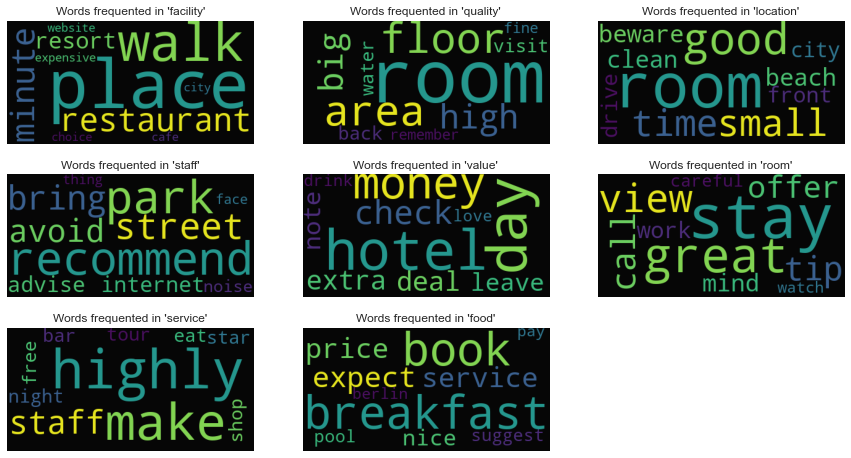

In [ ]:
content = dominant_words[0]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.figure(figsize = (15,8))
plt.subplot(3,3,1)
plt.axis("off")
plt.title("Words frequented in 'facility'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[1]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,2)
plt.axis("off")
plt.title("Words frequented in 'quality'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[2]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,3)
plt.axis("off")
plt.title("Words frequented in 'location'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[3]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,4)
plt.axis("off")
plt.title("Words frequented in 'staff'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[4]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,5)
plt.axis("off")
plt.title("Words frequented in 'value'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[5]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,6)
plt.axis("off")
plt.title("Words frequented in 'room'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[6]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,7)
plt.axis("off")
plt.title("Words frequented in 'service'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = dominant_words[7]
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,8)
plt.axis("off")
plt.title("Words frequented in 'food'", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

plt.show()

In [ ]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.194471 -0.173648       1        1  12.708693
3     -0.219810 -0.141794       2        1  12.598879
7     -0.074654 -0.233684       3        1  12.582955
5     -0.192096  0.252874       4        1  12.547338
2      0.203880 -0.077993       5        1  12.449478
1      0.217663  0.229210       6        1  12.400836
6     -0.175346  0.031246       7        1  12.394211
0      0.045892  0.113788       8        1  12.317611, topic_info=          Term        Freq       Total Category  logprob  loglift
3         room  118.000000  118.000000  Default  30.0000  30.0000
2        hotel  128.000000  128.000000  Default  29.0000  29.0000
93   recommend   92.000000   92.000000  Default  28.0000  28.0000
94        stay   85.000000   85.000000  Default  27.0000  27.0000
96        good   46.000000   46.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
2        hotel    6.686226  128.909257   Topic8  -4.3014  -0.8649
322     street    4.011736   21.158537   Topic8  -4.8122   0.4313
9        early    2.674490    7.931395   Topic8  -5.2176   1.0071
411       give    2.674490    5.213902   Topic8  -5.2176   1.4266
453     couple    2.674490    4.065281   Topic8  -5.2176   1.6754

[457 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1047      8  1.121709     00
532       1  0.797136     10
532       4  0.132856     10
365       1  1.199151    100
167       4  0.785841     19
...     ...       ...    ...
440       5  0.974483   work
356       3  0.787584  world
546       6  1.014539  worth
372       3  0.787584   yard
298       7  0.719016   year

[475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 6, 3, 2, 7, 1])

We can clearly see that in the word clouds that the 8 aspects of the model is showing some unique key words rather than the other no of clusters but in the topics there are some overlappig between the clusters, but analyzing the unique words and dominant topic count as two we can say that this 8 aspects are better than the 12 aspects we got

#### BoW with Count Vectorizer

In [ ]:
# Assign the news articles to the clustered_data
def assign_words_to_clusters(cluster_data):
    for cluster_num, cluster_details in cluster_data.items():
        global cluster_zero
        global cluster_one
        global cluster_two
        global cluster_three
        global cluster_four
        global cluster_five
        global cluster_six
        global cluster_seven
        if (cluster_num == 0):
            cluster_zero = cluster_details['words']
        if (cluster_num == 1):
            cluster_one = cluster_details['words']
        if (cluster_num == 2):
            cluster_two = cluster_details['words']
        if (cluster_num == 3):
            cluster_three = cluster_details['words']
        if (cluster_num == 4):
            cluster_four = cluster_details['words']
        if (cluster_num == 5):
            cluster_five = cluster_details['words']
        if (cluster_num == 6):
            cluster_six = cluster_details['words']
        if (cluster_num == 7):
            cluster_seven = cluster_details['words']
            
            
# Get the named cluster label based on keywords 
def get_Cluster_label(title):
    if (title in cluster_zero):
        return "facility"
    if (title in cluster_one):
        return "quality"
    if (title in cluster_two):
        return "location"
    if (title in cluster_three):
        return "staff"
    if (title in cluster_four):
        return "value"
    if (title in cluster_five):
        return "room"
    if (title in cluster_six):
        return "service"
    if (title in cluster_seven):
        return "food"
    
def get_Cluster_id(title):
    if (title in cluster_zero):
        return 0
    if (title in cluster_one):
        return 1
    if (title in cluster_two):
        return 2
    if (title in cluster_three):
        return 3
    if (title in cluster_four):
        return 4
    if (title in cluster_five):
        return 5
    if (title in cluster_six):
        return 6
    if (title in cluster_seven):
        return 7
    

# Write to csv in-order to complete compative study report
def write_to_csv(dataset, path_name):
    csv_record = []
    for i in range(len(dataset)):
        if isinstance(dataset.iloc[i,:9].count_vect_clusters, int) is False and (dataset.iloc[i,:9].count_vect_clusters) > 0:
            text = ""
            for j in range(len(dataset.iloc[i,:9].stop_words_removed_lemmatized)):
                text+=dataset.iloc[i,:9].stop_words_removed_lemmatized[j]+" "
            suggestions_row_data = []
            title = dataset.iloc[i,:9].hotel_name                                     
            body = dataset.iloc[i,:9].reviews                          
            cleaned_data = text.strip()  
            cluster_label = get_Cluster_label(dataset.iloc[i,:9].stop_words_removed_lemmatized)
            cluster_id =get_Cluster_id(dataset.iloc[i,:9].stop_words_removed_lemmatized)
            suggestions_row_data.append(title)
            suggestions_row_data.append(body)
            suggestions_row_data.append(cleaned_data)
            suggestions_row_data.append(cluster_label)
            suggestions_row_data.append(cluster_id)
            csv_record.append(suggestions_row_data)
    suggestionsbowDf = pd.DataFrame(csv_record, columns = ['Title', 'Body', 'Cleaned Data', 'Cluster','cluster_id'])
    suggestionsbowDf.to_csv(path_name, sep=',', encoding='utf-8')



# Assign cleaned data set as 3rd column in the corpus
suggestion_df['count_vect_clusters'] = count_vect_clusters
# # Identify the the cluster list
assign_words_to_clusters(cluster_data)

write_to_csv(suggestion_df, './clustered_data_bow.csv')

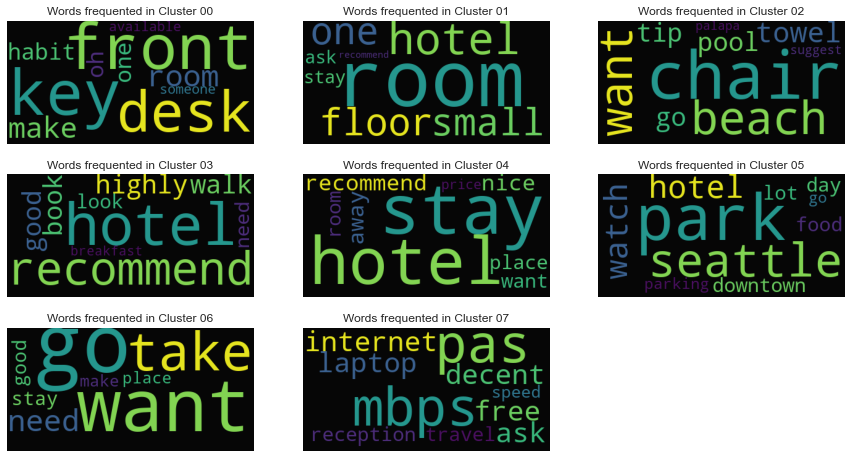

In [ ]:
content = cluster_data[0]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.figure(figsize = (15,8))
plt.subplot(3,3,1)
plt.axis("off")
plt.title("Words frequented in Cluster 00", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[1]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,2)
plt.axis("off")
plt.title("Words frequented in Cluster 01", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[2]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,3)
plt.axis("off")
plt.title("Words frequented in Cluster 02", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[3]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,4)
plt.axis("off")
plt.title("Words frequented in Cluster 03", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[4]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,5)
plt.axis("off")
plt.title("Words frequented in Cluster 04", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[5]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,6)
plt.axis("off")
plt.title("Words frequented in Cluster 05", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[6]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,7)
plt.axis("off")
plt.title("Words frequented in Cluster 06", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

content = cluster_data[7]['key_features']
wc = WordCloud(background_color = "black", max_words = 2000)
wc.generate((' '.join([str(elem) for elem in content])).replace("\'",""))
plt.subplot(3,3,8)
plt.axis("off")
plt.title("Words frequented in Cluster 07", fontsize = 12)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

plt.show()

***Trying new ways to check whether the 8 clusters are good***

#### ***Testing LDA Model***

In [ ]:
# read testing data
testDataC = pd.read_csv("./dataset/test.csv",skipinitialspace = True)
# name the columns
testDataC.columns = ['id', 'reviews','label']
testDataC.head()

,id,reviews,label
0,7,"also, the hotel would be advised to forget the...","food, facilities"
1,20,and curtains could do with a splash of colour.,"facility, room"
2,25,the public areas are those you would expect fr...,"value, facility, quality"
3,33,"the comforter, drapes and furniture were in ne...","facility, room, quality"
4,43,the carpets and furniture are in need of renewal.,"value, facility, quality"


In [ ]:
testDataC['reviews_fixed']=testDataC['reviews'].apply(lambda cw : cleantext(cw))
testDataC['tokenized_reviews'] = testDataC['reviews_fixed'].apply(lambda x : tokenizer.tokenize(x.lower()))
testDataC['stop_words_removed']=testDataC['tokenized_reviews'].apply(lambda x : remove_stop_words(x))
testDataC['stop_words_removed_lemmatized']=testDataC['stop_words_removed'].apply(lambda x : lemmatize_text(x))

testDataC.head()

,id,reviews,label,reviews_fixed,tokenized_reviews,stop_words_removed,stop_words_removed_lemmatized
0,7,"also, the hotel would be advised to forget the...","food, facilities",also the hotel would be advised to forget the ...,"[also, the, hotel, would, be, advised, to, for...","[also, hotel, would, advised, forget, waffles,...","[also, hotel, would, advise, forget, waffle, c..."
1,20,and curtains could do with a splash of colour.,"facility, room",and curtains could do with splash of colour,"[and, curtains, could, do, with, splash, of, c...","[curtains, could, splash, colour]","[curtain, could, splash, colour]"
2,25,the public areas are those you would expect fr...,"value, facility, quality",the public areas are those you would expect fr...,"[the, public, areas, are, those, you, would, e...","[public, areas, would, expect, star, hotel, ne...","[public, area, would, expect, star, hotel, nee..."
3,33,"the comforter, drapes and furniture were in ne...","facility, room, quality",the comforter drapes and furniture we are in n...,"[the, comforter, drapes, and, furniture, we, a...","[comforter, drapes, furniture, need, replacement]","[comforter, drape, furniture, need, replacement]"
4,43,the carpets and furniture are in need of renewal.,"value, facility, quality",the carpets and furniture are in need of renewal,"[the, carpets, and, furniture, are, in, need, ...","[carpets, furniture, need, renewal]","[carpet, furniture, need, renewal]"


In [ ]:
test_label_dict = {}
def count_labels(arr):
    for i in range(len(arr)):
        temp = arr[i].split(",")
        for j in range(len(temp)):
            temp[j]=temp[j].strip()
            if(temp[j] not in test_label_dict):
                test_label_dict[temp[j]]=1
            else:
                test_label_dict[temp[j]]+=1
    print(test_label_dict)

count_labels(testDataC['label'].to_list())

{'food': 8, 'facilities': 1, 'facility': 29, 'room': 28, 'value': 13, 'quality': 24, 'service': 19, '': 2, 'meal': 1, 'staff': 13, 'location': 1}


In [ ]:
#there are 10 categories replace meal->food and facilities->facility
def change_label_names(text):
    text_ = text.split(",")
    text_out =''
    for i in range(len(text_)):
        temp=text_[i].strip()
        if(temp=="meal"):
            temp="food"
        if(temp=="facilities"):
            temp="facility"
        text_out+=temp+","
    return text_out[0:len(text_out)-1]

testDataC['label']=testDataC['label'].apply(lambda x : change_label_names(x))
testDataC.head()

,id,reviews,label,reviews_fixed,tokenized_reviews,stop_words_removed,stop_words_removed_lemmatized
0,7,"also, the hotel would be advised to forget the...","food,facility",also the hotel would be advised to forget the ...,"[also, the, hotel, would, be, advised, to, for...","[also, hotel, would, advised, forget, waffles,...","[also, hotel, would, advise, forget, waffle, c..."
1,20,and curtains could do with a splash of colour.,"facility,room",and curtains could do with splash of colour,"[and, curtains, could, do, with, splash, of, c...","[curtains, could, splash, colour]","[curtain, could, splash, colour]"
2,25,the public areas are those you would expect fr...,"value,facility,quality",the public areas are those you would expect fr...,"[the, public, areas, are, those, you, would, e...","[public, areas, would, expect, star, hotel, ne...","[public, area, would, expect, star, hotel, nee..."
3,33,"the comforter, drapes and furniture were in ne...","facility,room,quality",the comforter drapes and furniture we are in n...,"[the, comforter, drapes, and, furniture, we, a...","[comforter, drapes, furniture, need, replacement]","[comforter, drape, furniture, need, replacement]"
4,43,the carpets and furniture are in need of renewal.,"value,facility,quality",the carpets and furniture are in need of renewal,"[the, carpets, and, furniture, are, in, need, ...","[carpets, furniture, need, renewal]","[carpet, furniture, need, renewal]"


In [ ]:
from operator import itemgetter
def test_lda(arr):
    doc_vector = ldamallet.id2word.doc2bow(arr)
    doc_topics = ldamallet[doc_vector]
    topics =[]
    final=[]
    for i in range(len(doc_topics)):
        topics.append(doc_topics[i])
    top3=sorted(topics,key=lambda x: x[1], reverse=True)
    for i in range(3):
        final.append(top3[i][0])
    return final

testDataC['top3_topics']=testDataC['stop_words_removed_lemmatized'].apply(lambda x : test_lda(x))

In [ ]:
testDataC['top3_cluster_tag'] = testDataC['top3_topics'].apply(lambda x:tag_the_gensim_output(x))
testDataC.head()

,id,reviews,label,reviews_fixed,tokenized_reviews,stop_words_removed,stop_words_removed_lemmatized,top3_topics,top3_cluster_tag
0,7,"also, the hotel would be advised to forget the...","food,facility",also the hotel would be advised to forget the ...,"[also, the, hotel, would, be, advised, to, for...","[also, hotel, would, advised, forget, waffles,...","[also, hotel, would, advise, forget, waffle, c...","[4, 1, 2]","[value, quality, location]"
1,20,and curtains could do with a splash of colour.,"facility,room",and curtains could do with splash of colour,"[and, curtains, could, do, with, splash, of, c...","[curtains, could, splash, colour]","[curtain, could, splash, colour]","[3, 7, 6]","[staff, food, service]"
2,25,the public areas are those you would expect fr...,"value,facility,quality",the public areas are those you would expect fr...,"[the, public, areas, are, those, you, would, e...","[public, areas, would, expect, star, hotel, ne...","[public, area, would, expect, star, hotel, nee...","[6, 0, 2]","[service, facility, location]"
3,33,"the comforter, drapes and furniture were in ne...","facility,room,quality",the comforter drapes and furniture we are in n...,"[the, comforter, drapes, and, furniture, we, a...","[comforter, drapes, furniture, need, replacement]","[comforter, drape, furniture, need, replacement]","[0, 1, 2]","[facility, quality, location]"
4,43,the carpets and furniture are in need of renewal.,"value,facility,quality",the carpets and furniture are in need of renewal,"[the, carpets, and, furniture, are, in, need, ...","[carpets, furniture, need, renewal]","[carpet, furniture, need, renewal]","[5, 6, 0]","[room, service, facility]"


In [ ]:
#check accuracy
global correct
global incorrect
global total

def accuracy_lda(df):
    correct=0
    incorrect=0
    total=0
    for i in range(len(df)):
        labels = (df.iloc[i,:3].label).split(",")
        
        for j in range(len(labels)):
            if labels[j] in df.iloc[i,:].top3_cluster_tag:
                correct+=1
            else:
                incorrect+=1
            total+=1
    print("\nAccuracy:"+(str)(correct/total)) 

accuracy_lda(testDataC)


Accuracy:0.31654676258992803


***Why dataset accuracy is low and ways to imrpove it***

In this data set we can see that the suggestion data are comparatively low, to have more suggestion data we can scrape more data from internet related to sugesstion or we can use synonyms for suggestions and them we can have a balanced data set of suggestions and non-sugestions

Review the content of each cluster manually and come up with suitable labels for each cluster. These labels can be new ones. Then a supervised ML model can be trained to using this labeled data. Optimal supervised learning techniques such as SVM, Decision Tree, KNeighborsClassifier etc can be used to build the mode. This model can be used to predict the label for given suggestions.
Also, we can improve this clutering mechanism bt considerign below things.

<ul>
    <li>Increase the data-set count</li>
    <li>Remove the stopwords related to domain</li>
    <li>Check the English dictionary along with domain words.</li>
    <li>Increase slang words and contraction list data</li>
</ul>

### ***Tryout neural networks***

### For the 12 clusters Gensim

In [ ]:
import pandas as pd
import numpy as np
import nltk

# This data is the processed data written after doing the first part of the course work
textDf = pd.read_csv('./clustered_data.csv')
textDf.isnull().values.any()

#split data to X and Y(labels)
textDf_dataset = textDf['Cleaned Data']
textDf_labels = textDf['Dominant_Topic']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# split in to a test set
label_encoder = LabelEncoder()
text_X_train, text_X_test, text_Y_train, text_Y_test \
= train_test_split(textDf_dataset, label_encoder.fit_transform(textDf_labels), test_size=0.2, random_state=1)

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# This will be the maximum number of words from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 1000 most common words in our case
num_words = 1000
# our maximum sentence length will be determined by searching our sentences for the one of maximum length, 
# and padding characters will be '0'
pad_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(text_X_train)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(text_X_train)
test_sequences = tokenizer.texts_to_sequences(text_X_test)
# val_sequences = tokenizer.texts_to_sequences(text_X_val)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences (pad_sequece makes the sentences in input dataset uniform in length)
X_train = pad_sequences(train_sequences, padding=pad_type,maxlen=maxlen)
X_test = pad_sequences(test_sequences, padding=pad_type,maxlen=maxlen)

Y_train = to_categorical(text_Y_train)
Y_test = to_categorical(text_Y_test)

vocabSize = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Output the results of our work
print("\nVocab size:\n", vocabSize)
print("\nPadded training sequences:\n", X_train[0, :10])
print("\nPadded training shape:", X_train.shape)
print("Training sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(X_train))



Vocab size:
 1232

Padded training sequences:
 [ 96  29 462 463 464 189 465   2 466 467]

Padded training shape: (358, 31)
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [ ]:
from numpy import asarray
from numpy import zeros

glove_file = open("./glove/glove.6B.100d.txt", encoding="utf8")
embeddings_dictionary = dict()

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()


In [ ]:
# It's used check whether the passed word is available in the dictionary
embedding_matrix = zeros((vocabSize, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Using LSTM for RNN
#### Creating the model
Here we will create a simple model with one input layer (embedding layer), one LSTM layer with 256 neurons and one dense layer that will act as the output layer as well. Since we have 8 possible outputs, the number of neurons will be 8 and the activation function will be softmax. We will use the categorical_crossentropy as our loss function and adam as the optimization function.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Dense, InputLayer

embeddingDim = 100

model = Sequential()
# The first layer is the embedded layer that uses max length vectors to represent each word.
model.add(layers.Embedding(input_dim=vocabSize, 
                           output_dim=embeddingDim,
                           weights=[embedding_matrix],
                           input_length=maxlen))
model.add(SpatialDropout1D(0.2))
# The next layer is the LSTM layer with 256 memory units.
model.add(layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2))
# The output layer must create 13 output values, one for each class.
model.add(Dense(12, activation='softmax'))
# Activation function is softmax for multi-class classification.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 100)           123200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 31, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1255424   
_________________________________________________________________
dense (Dense)                (None, 12)                6156      
Total params: 1,384,780
Trainable params: 1,384,780
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 1s 675ms/step - loss: 2.4863 - accuracy: 0.0699 - val_loss: 2.4854 - val_accuracy: 0.0833
Epoch 2/20
1/1 [==============================] - 0s 199ms/step - loss: 2.4749 - accuracy: 0.1469 - val_loss: 2.4889 - val_accuracy: 0.0556
Epoch 3/20
1/1 [==============================] - 0s 214ms/step - loss: 2.4573 - accuracy: 0.1189 - val_loss: 2.5593 - val_accuracy: 0.0556
Epoch 4/20
1/1 [==============================] - 0s 189ms/step - loss: 2.4459 - accuracy: 0.1259 - val_loss: 2.5024 - val_accuracy: 0.0556
Epoch 5/20
1/1 [==============================] - 0s 184ms/step - loss: 2.4315 - accuracy: 0.1294 - val_loss: 2.4959 - val_accuracy: 0.0556
Epoch 6/20
1/1 [==============================] - 0s 211ms/step - loss: 2.4283 - accuracy: 0.1224 - val_loss: 2.5029 - val_accuracy: 0.0556
Epoch 7/20
1/1 [==============================] - 0s 186ms/step - loss: 2.4078 - accuracy: 0.1399 - val_loss: 2.5355 - val_accuracy: 0.0694
Epoch 8/20
1/1 [====

In [ ]:
# Below method will be printing the test score and accurecy of the system
score = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 73ms/step - loss: 2.6199 - accuracy: 0.1444
Test Score: 2.6199145317077637
Test Accuracy: 0.14444445073604584


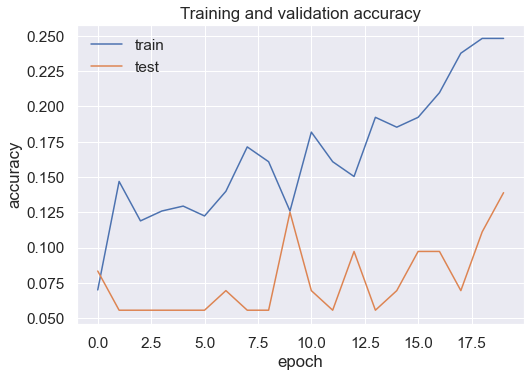

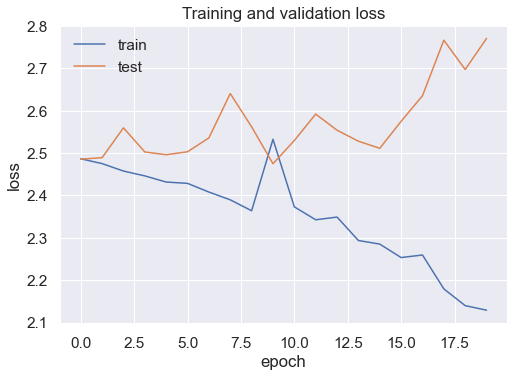

In [ ]:
import matplotlib.pyplot as plt

# Below method used to used to print the 
def print_plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    
# Display LSTM both accuracy and loss
print_plot_history(history)

#### Using CNN
Below code used to contains about CNN

In [ ]:
# Setup a Convulation Neural Network (CNN)
model_cnn = Sequential()
model_cnn.add(layers.Embedding(vocabSize, 100, input_length=maxlen))

model_cnn.add(layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(250, activation='relu'))

model_cnn.add(layers.Dense(12, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 100)           123200    
_________________________________________________________________
conv1d (Conv1D)              (None, 31, 512)           154112    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 512)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1920250   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3012      
Total params: 2,200,574
Trainable params: 2,200,574
Non-trainable params: 0
____________________________________________

In [ ]:
history_cnn = model_cnn.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 0s 160ms/step - loss: 2.4841 - accuracy: 0.0944 - val_loss: 2.4924 - val_accuracy: 0.0694
Epoch 2/20
1/1 [==============================] - 0s 19ms/step - loss: 2.4512 - accuracy: 0.1119 - val_loss: 2.5153 - val_accuracy: 0.0694
Epoch 3/20
1/1 [==============================] - 0s 18ms/step - loss: 2.4242 - accuracy: 0.1154 - val_loss: 2.5269 - val_accuracy: 0.0694
Epoch 4/20
1/1 [==============================] - 0s 23ms/step - loss: 2.4006 - accuracy: 0.1923 - val_loss: 2.5109 - val_accuracy: 0.0556
Epoch 5/20
1/1 [==============================] - 0s 22ms/step - loss: 2.3678 - accuracy: 0.2238 - val_loss: 2.4938 - val_accuracy: 0.0556
Epoch 6/20
1/1 [==============================] - 0s 20ms/step - loss: 2.3337 - accuracy: 0.2343 - val_loss: 2.4896 - val_accuracy: 0.0556
Epoch 7/20
1/1 [==============================] - 0s 21ms/step - loss: 2.2944 - accuracy: 0.2902 - val_loss: 2.4951 - val_accuracy: 0.0556
Epoch 8/20
1/1 [==========

In [ ]:
score = model_cnn.evaluate(X_test, Y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 3ms/step - loss: 2.3356 - accuracy: 0.2000
Test Score: 2.3356475830078125
Test Accuracy: 0.20000000298023224


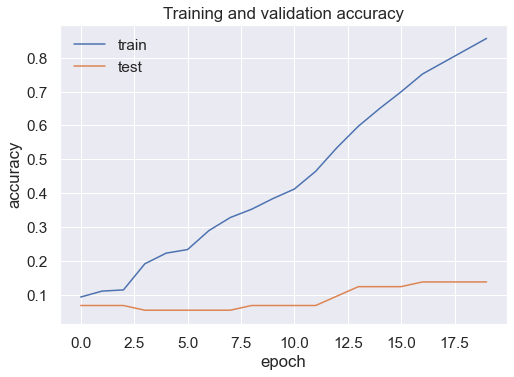

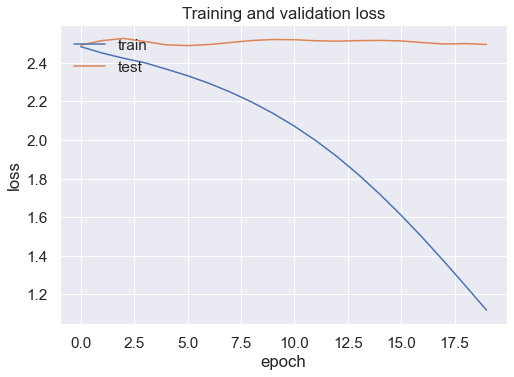

In [ ]:
# Display CNN both accuracy and loss
print_plot_history(history_cnn)

#### Compartive Study Explanation
According to the above 2 diagrams we can see in RNN the training and testing accuracies are closer than CNN\'s. Hence we can identify RNN as the better model.

### For the Bow CountVectorizer clusters
#### RNN With LSTM for 8 clusters
Here we have to go with 7 layers because the cluster 0 is having only one value and we need to remove that value to have good results

In [ ]:
import pandas as pd
import numpy as np
import nltk

# This data is the processed data written after doing the first part of the course work
textDf8 = pd.read_csv('./clustered_data_bow.csv')
textDf8.isnull().values.any()

#split data to X and Y(labels)
textDf_dataset8 = textDf8['Cleaned Data']
textDf_labels8 = textDf8['Cluster']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# split in to a test set
label_encoder = LabelEncoder()
text8_X_train, text8_X_test, text8_Y_train, text8_Y_test \
= train_test_split(textDf_dataset8, label_encoder.fit_transform(textDf_labels8), test_size=0.2, random_state=1)

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# This will be the maximum number of words from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 1000 most common words in our case
num_words = 1000
# our maximum sentence length will be determined by searching our sentences for the one of maximum length, 
# and padding characters will be '0'
pad_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(text8_X_train)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train8_sequences = tokenizer.texts_to_sequences(text8_X_train)
test8_sequences = tokenizer.texts_to_sequences(text8_X_test)

# Get max training sequence length
maxlen = max([len(x) for x in train8_sequences])

# Pad the training sequences (pad_sequece makes the sentences in input dataset uniform in length)
X8_train = pad_sequences(train8_sequences, padding=pad_type,maxlen=maxlen)
X8_test = pad_sequences(test8_sequences, padding=pad_type,maxlen=maxlen)

Y8_train = to_categorical(text8_Y_train)
Y8_test = to_categorical(text8_Y_test)

vocabSize8 = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Output the results of our work
print("\nVocab size:\n", vocabSize8)
print("\nPadded training sequences:\n", X8_train[0, :10])
print("\nPadded training shape:", X8_train.shape)
print("Training sequences data type:", type(train8_sequences))
print("Padded Training sequences data type:", type(X8_train))


Vocab size:
 1254

Padded training sequences:
 [ 78  40 436 437 438 187 439   2 440 441]

Padded training shape: (357, 31)
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Dense, InputLayer

embeddingDim = 100

model8 = Sequential()
# The first layer is the embedded layer that uses max length vectors to represent each word.
model8.add(layers.Embedding(input_dim=vocabSize8, 
                           output_dim=embeddingDim,
                           input_length=maxlen))
model8.add(SpatialDropout1D(0.2))
# The next layer is the LSTM layer with 256 memory units.
model8.add(layers.LSTM(256, dropout=0.2, recurrent_dropout=0.2))
# The output layer must create 7 output values, one for each class.
model8.add(Dense(7, activation='softmax'))
# Activation function is softmax for multi-class classification.
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model8.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 100)           125400    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 31, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 492,767
Trainable params: 492,767
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history8 = model8.fit(X8_train, Y8_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
2/2 [==============================] - 1s 251ms/step - loss: 1.9464 - accuracy: 0.1123 - val_loss: 1.8411 - val_accuracy: 0.5833
Epoch 2/20
2/2 [==============================] - 0s 91ms/step - loss: 1.8531 - accuracy: 0.4912 - val_loss: 1.6364 - val_accuracy: 0.5833
Epoch 3/20
2/2 [==============================] - 0s 86ms/step - loss: 1.6881 - accuracy: 0.4912 - val_loss: 1.2743 - val_accuracy: 0.5833
Epoch 4/20
2/2 [==============================] - 0s 95ms/step - loss: 1.4967 - accuracy: 0.4912 - val_loss: 1.1824 - val_accuracy: 0.5833
Epoch 5/20
2/2 [==============================] - 0s 92ms/step - loss: 1.3866 - accuracy: 0.4912 - val_loss: 1.2291 - val_accuracy: 0.5833
Epoch 6/20
2/2 [==============================] - 0s 83ms/step - loss: 1.3820 - accuracy: 0.4912 - val_loss: 1.2070 - val_accuracy: 0.5833
Epoch 7/20
2/2 [==============================] - 0s 93ms/step - loss: 1.3719 - accuracy: 0.4912 - val_loss: 1.1736 - val_accuracy: 0.5833
Epoch 8/20
2/2 [==========

In [ ]:
# Below method will be printing the test score and accurecy of the system
score8 = model8.evaluate(X8_test, Y8_test, verbose=1)
print("Test Score:", score8[0])
print("Test Accuracy:", score8[1])

3/3 [==============================] - 0s 12ms/step - loss: 1.0424 - accuracy: 0.6667
Test Score: 1.042437195777893
Test Accuracy: 0.6666666865348816


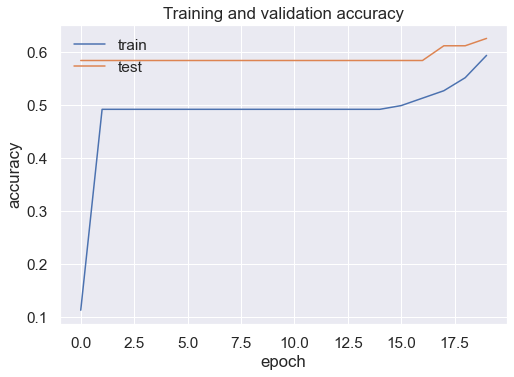

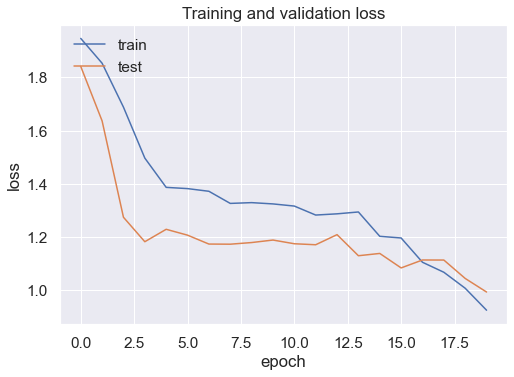

In [ ]:
# Display LSTM both accuracy and loss
print_plot_history(history8)

#### Using CNN for 8 clusters

In [ ]:
# Setup a Convulation Neural Network (CNN)
model8_cnn = Sequential()
model8_cnn.add(layers.Embedding(vocabSize, 100, input_length=maxlen))

model8_cnn.add(layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
model8_cnn.add(layers.MaxPooling1D(pool_size=2))
model8_cnn.add(layers.Flatten())
model8_cnn.add(layers.Dense(250, activation='relu'))

model8_cnn.add(layers.Dense(7, activation='softmax'))
model8_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model8_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 31, 100)           123200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 512)           154112    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 512)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               1920250   
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1757      
Total params: 2,199,319
Trainable params: 2,199,319
Non-trainable params: 0
____________________________________________

In [ ]:
history8_cnn = model8_cnn.fit(X8_train, Y8_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 0s 168ms/step - loss: 1.9478 - accuracy: 0.0877 - val_loss: 1.7204 - val_accuracy: 0.5833
Epoch 2/20
1/1 [==============================] - 0s 22ms/step - loss: 1.7457 - accuracy: 0.4912 - val_loss: 1.4649 - val_accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 0s 29ms/step - loss: 1.5399 - accuracy: 0.4912 - val_loss: 1.2699 - val_accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 0s 21ms/step - loss: 1.4227 - accuracy: 0.4912 - val_loss: 1.2288 - val_accuracy: 0.5833
Epoch 5/20
1/1 [==============================] - 0s 22ms/step - loss: 1.4197 - accuracy: 0.4912 - val_loss: 1.1831 - val_accuracy: 0.5833
Epoch 6/20
1/1 [==============================] - 0s 20ms/step - loss: 1.3536 - accuracy: 0.4912 - val_loss: 1.1767 - val_accuracy: 0.5833
Epoch 7/20
1/1 [==============================] - 0s 22ms/step - loss: 1.3042 - accuracy: 0.4912 - val_loss: 1.2261 - val_accuracy: 0.5833
Epoch 8/20
1/1 [==========

In [ ]:
score8 = model8_cnn.evaluate(X8_test, Y8_test, verbose=1)

print("Test Score:", score8[0])
print("Test Accuracy:", score8[1])

3/3 [==============================] - 0s 3ms/step - loss: 1.0539 - accuracy: 0.6889
Test Score: 1.0539371967315674
Test Accuracy: 0.6888889074325562


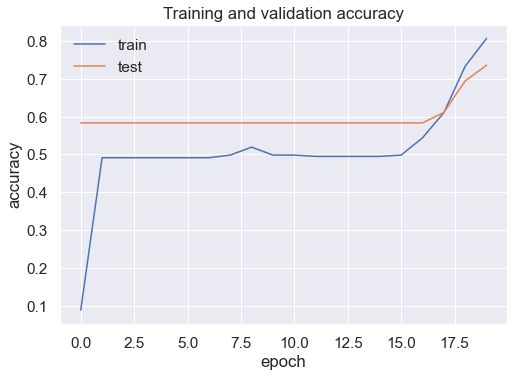

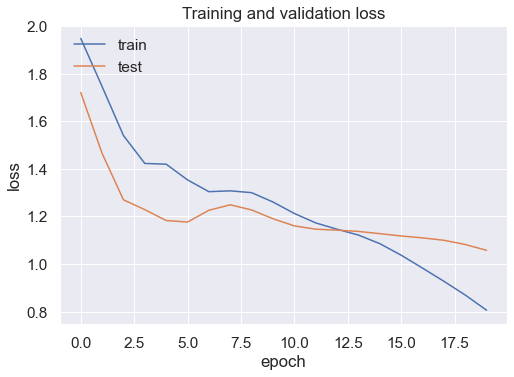

In [ ]:
print_plot_history(history8_cnn)

For the 8 clusters one RNN is having accuracy around 61% while CNN has an accuracy of 67% so CNN is better with the 8 clustering